In [1]:
import numpy as np
import torch as tr
import torch.nn as nn
from torch import distributions
from torch.nn.parameter import Parameter
import phi4_mg as m

tr.set_default_dtype(tr.float64) 

#!/usr/local/bin/python3
import time
import numpy as np
import torch as tr
import phi4 as s
import integrators as integ
import update as u

import matplotlib.pyplot as plt
from tqdm import tqdm

import argparse
import sys

import time
from stacked_model import *
import Gamma_error as gm

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
os.environ["PATH"] = "/sciclone/home/yacahuanamedra/texlive/bin/x86_64-linux:" + os.environ["PATH"]

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amsfonts}')
import pickle


from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

mpl.rc('font', **font)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

mpl.rc('font', **font)

## Device

In [40]:
device = tr.device("cpu")
dev=1
# Check that MPS is available
if not tr.backends.mps.is_available():
    if not tr.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
     if (dev >= 0 ):
          device = tr.device("mps")

# Check that CUDA is available
if not tr.cuda.is_available():
    if not tr.backends.cuda.is_built():
        print("CUDA not available because the current PyTorch install was not "
              "built with CUDA enabled.")
    else:
        print("CUDA not available or you do not have a GPU on this machine.")

else:
     if (dev >= 0 ):
          device = tr.device("cuda:"+str(dev))


    
print(f"Using {device} device")

MPS not available because the current PyTorch install was not built with MPS enabled.
Using cuda:1 device


## Discrete action

\begin{equation}
S[\phi] = \sum_{x} \left[ 
    \frac{1}{2} \tilde{m} \, \phi(x)^2 
    + \frac{\lambda}{24} \, \phi(x)^4 
    - \sum_{\mu=1}^{N_d} \phi(x) \, \phi(x + \hat{\mu}) 
\right]
\end{equation}

## Some observables

Phase in the code $\delta_n=e^{\frac{2i\pi}{L}n}$ with $p_n=\frac{2\pi}{L}n$

\begin{align}
\text{Field average or magnetization:} \quad
\langle \phi \rangle &= \frac{1}{V} \sum_x \phi(x) \\[8pt]
\text{Magnetic susceptibility:} \quad
\chi_m &= V \cdot \langle \phi \rangle^2 \\[8pt]
\text{Two-point correlator at momentum $p$}: \quad
C_2(p) &= V \cdot \left| \frac{1}{V} \sum_x \phi(x) \, e^{i p_n x} \right|^2 \\[8pt]
\text{Energy density:} \quad
E &= \frac{S[\phi]}{V}
\end{align}

## HMC loop

In [3]:
def get_observables_hist(sg,hmc, phi, Nwarm, Nmeas, Nskip,pp="no"):

    tic=time.perf_counter()
    Vol=sg.Vol
    lat=[phi.shape[1], phi.shape[2]]
    toc=time.perf_counter()

    print(f"time {(toc - tic)*1.0e6/Nwarm:0.4f} micro-seconds per HMC trajecrory")

    lC2p = []
    lchi_m = []
    E = []
    av_phi = []
    phase=tr.tensor(np.exp(1j*np.indices(tuple(lat))[0]*2*np.pi/lat[0]),dtype=sg.dtype,device=sg.device)
    for k in range(Nmeas):
        ttE = sg.action(phi)/Vol
        E.append(ttE)
        av_sigma = tr.mean(phi.view(sg.Bs,Vol),axis=1)
        av_phi.append(av_sigma)
        chi_m = av_sigma*av_sigma*Vol
        p1_av_sig = tr.mean(phi.view(sg.Bs,Vol)*phase.view(1,Vol),axis=1)
        C2p = tr.real(tr.conj(p1_av_sig)*p1_av_sig)*Vol
        if(k%100==0) and pp=="print":
            print("k= ",k,"(av_phi,chi_m, c2p, E) ", av_sigma.mean().numpy(),chi_m.mean().numpy(),C2p.mean().numpy(),ttE.mean().numpy())
            print("len(C2p): ", len(C2p))
        lC2p.append(C2p)
        lchi_m.append(chi_m)
        ## HMC update but also V cycle
        phi = hmc.evolve(phi,Nskip)

    return lC2p, lchi_m, E, av_phi, phi

def get_observables(lC2p, lchi_m, E, av_phi, phi):

    Vol=phi.shape[1]*phi.shape[2]
    lat=[phi.shape[1], phi.shape[2]]
    
    m_phi, e_phi = average(av_phi)
    print("m_phi: ",m_phi,e_phi)

    m_chi_m, e_chi_m = average(np.array(lchi_m) - (m_phi**2)*Vol)
    m_C2p, e_C2p     = average(lC2p)
    print(r"$\chi_m$: ",m_chi_m,'+/-', e_chi_m)
    print("C2p  : ",m_C2p,'+/-', e_C2p)
    avE,eE = average(E)
    print("E = ", avE ,'+/-',eE)

    xi = correlation_length(lat[0],m_chi_m, m_C2p)
    print("The correlation length is: ",xi)
    jphi   = np.array(jackknife(av_phi))
    jchi_m = np.array(jackknife(lchi_m)) - jphi**2 * Vol
    jC2p   = np.array(jackknife(lC2p))


    j_xi = correlation_length(lat[0],jchi_m,jC2p)

    m_xi,e_xi = average(j_xi)

    return m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi


def autocorrelation1(trace):
    #divide trace in 2
    trace=trace[0:trace.shape[0]]
    n=trace.shape[0]
    mean=tr.mean(trace)
    var=tr.var(trace)
    autocorr=tr.zeros_like(trace)
    for k in range(0,n-1):
        autocorr[k]=tr.sum((trace[0:n-k]-mean)*(trace[k:n]-mean))/(var*(n-k))
    return autocorr

    
def autocorrelation(trace):
    x = tr.as_tensor(trace, dtype=tr.float64)
    n = x.shape[0]
    x = x - x.mean()
    var = x.var(unbiased=False)
    acf = tr.zeros(n, dtype=x.dtype)
    for k in range(n):
        acf[k] = tr.dot(x[:n-k], x[k:]) / (var * (n - k))
    return acf # acf[0] == 1

#τ_int (Sokal: τ_int = 0.5 + sum_{t=1}^W ρ_t)
def integrated_autocorrelation_time(acf, max_lag=None):
    x = tr.as_tensor(acf, dtype=tr.float64)
    if x[0].abs().item() > 0:
        x = x / x[0]
    n = x.shape[0]
    if max_lag is None:
        W = 0
        for t in range(1, n):
            if (x[t] <= 0).item():
                break
            W = t
    else:
        W = min(int(max_lag), n - 1)
    return float(0.5 + x[1:W+1].sum().item())

def integrated_autocorrelation_time1(acf, max_lag=None):
    if max_lag is None:
        for t in range(1, len(acf)):
            if acf[t] < 0:
                max_lag = t
                break
        else:
            max_lag = len(acf) - 1
    return 0.5 + tr.sum(acf[1:max_lag])
def get_autocorrelationtime(av_phi, lchi_m):
    
    acf_phi = autocorrelation(tr.tensor(av_phi))
    #acf_phi = acf_phi / acf_phi[0]
    acf_suscept = autocorrelation(tr.tensor(lchi_m))
    max_lag=len(av_phi)//4
    print(acf_phi.shape)
    tau_int_phi = integrated_autocorrelation_time(acf_phi,max_lag)
    tau_int_suscept = integrated_autocorrelation_time(acf_suscept,max_lag)
    return tau_int_phi, tau_int_suscept

In [71]:
device = "cuda"
import integrators as i

mass_grid=np.linspace(-.58,-0.55,11)
L=16
lat = [L,L]
# This set of params is very very close to critical.
lam = 2.4
mas = -0.55
#
Nwarm = 1
Nmeas = 100
Nskip = 1
batch_size = 10

Vol = np.prod(lat)
sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device,dtype=tr.float64)
phi = sg.hotStart()
#plot
#plt.imshow(phi[0].cpu().numpy())
#plt.show()

mn2 = i.minnorm2(sg.force,sg.evolveQ,80,1.0)
mn2_autograd = i.minnorm2(sg.autoforce,sg.evolveQ,80,1.0)
print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
hmc = u.hmc(T=sg,I=mn2,verbose=False)
hmc_autograd = u.hmc(T=sg,I=mn2_autograd,verbose=False)
phinormal = hmc.evolve(phi,1)
phi_autograd = hmc_autograd.evolve(phi,1)



#plt.imshow(phi[0].cpu().numpy())
#plt.show()
lC2p, lchi_m, E, av_phi, phi = gm.get_observables_hist(sg, hmc, phi, Nwarm, Nmeas, Nskip)

#tau_phi,tau_chi = get_autocorrelationtime(av_phi, lchi_m)
#m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi=get_observables(lC2p, lchi_m, E, av_phi, phi)

torch.Size([10, 16, 16]) 256 tensor(-0.0195, device='cuda:0') tensor(1.0184, device='cuda:0')
time 1.8941 micro-seconds per HMC trajecrory


In [72]:
len(av_phi)

100

### Gamma analysis for phi4 observables

In [8]:
rep_ten=tr.stack(av_phi).T.unsqueeze(2).to("cpu") #cpu
replicas = gm.split_first_dim_to_list(rep_ten)

print(tr.stack(replicas).shape, rep_ten.shape)

f = lambda A: A[0]
results = gm.gamma_method_with_replicas(replicas, f, max_lag=5000)
print(f"F = {results['value']:.6f} ± {results['dvalue']:.6f} (±{results['ddvalue']:.6f})")
print(f"tau_int = {results['tau_int']:.3f} ± {results['dtau_int']:.3f}")
print(f"W_opt = {results['W_opt']}, Q = {results['Q']}")

torch.Size([100, 2000, 1]) torch.Size([100, 2000, 1])
Optimal window found: W = 1203
F = -0.001969 ± 0.055362 (±0.003708)
tau_int = 306.493 ± 41.052
W_opt = 1203, Q = 0.0


In [10]:
tr.stack(replicas).shape

torch.Size([100, 2000, 1])

In [ ]:
"""import torch as tr
tr.manual_seed(0)

N_total = 10000
obs = tr.exp(1.0 + 0.1 * tr.randn(N_total))  # A0 > 0
data = obs.unsqueeze(1)  # Shape [N, 1]
replicas =  tr.chunk(data, 5) # lista de 5 tensores [~2000, 1]
"""
rep_ten=tr.stack(av_phi).T.unsqueeze(2).to("cpu") #cpu
replicas = gm.split_first_dim_to_list(rep_ten)

print(tr.stack(replicas).shape, rep_ten.shape)

f = lambda A: A[0]
results = gm.gamma_method_with_replicas(replicas, f, max_lag=1000)
print(f"F = {results['value']:.6f} ± {results['dvalue']:.6f} (±{results['ddvalue']:.6f})")
print(f"tau_int = {results['tau_int']:.3f} ± {results['dtau_int']:.3f}")
print(f"W_opt = {results['W_opt']}, Q = {results['Q']}")


torch.Size([10, 2000, 1]) torch.Size([10, 2000, 1])
Optimal window found: W = 783
F = 0.024354 ± 0.174871 (±0.027026)
tau_int = 305.813 ± 94.524
W_opt = 783, Q = 0.0


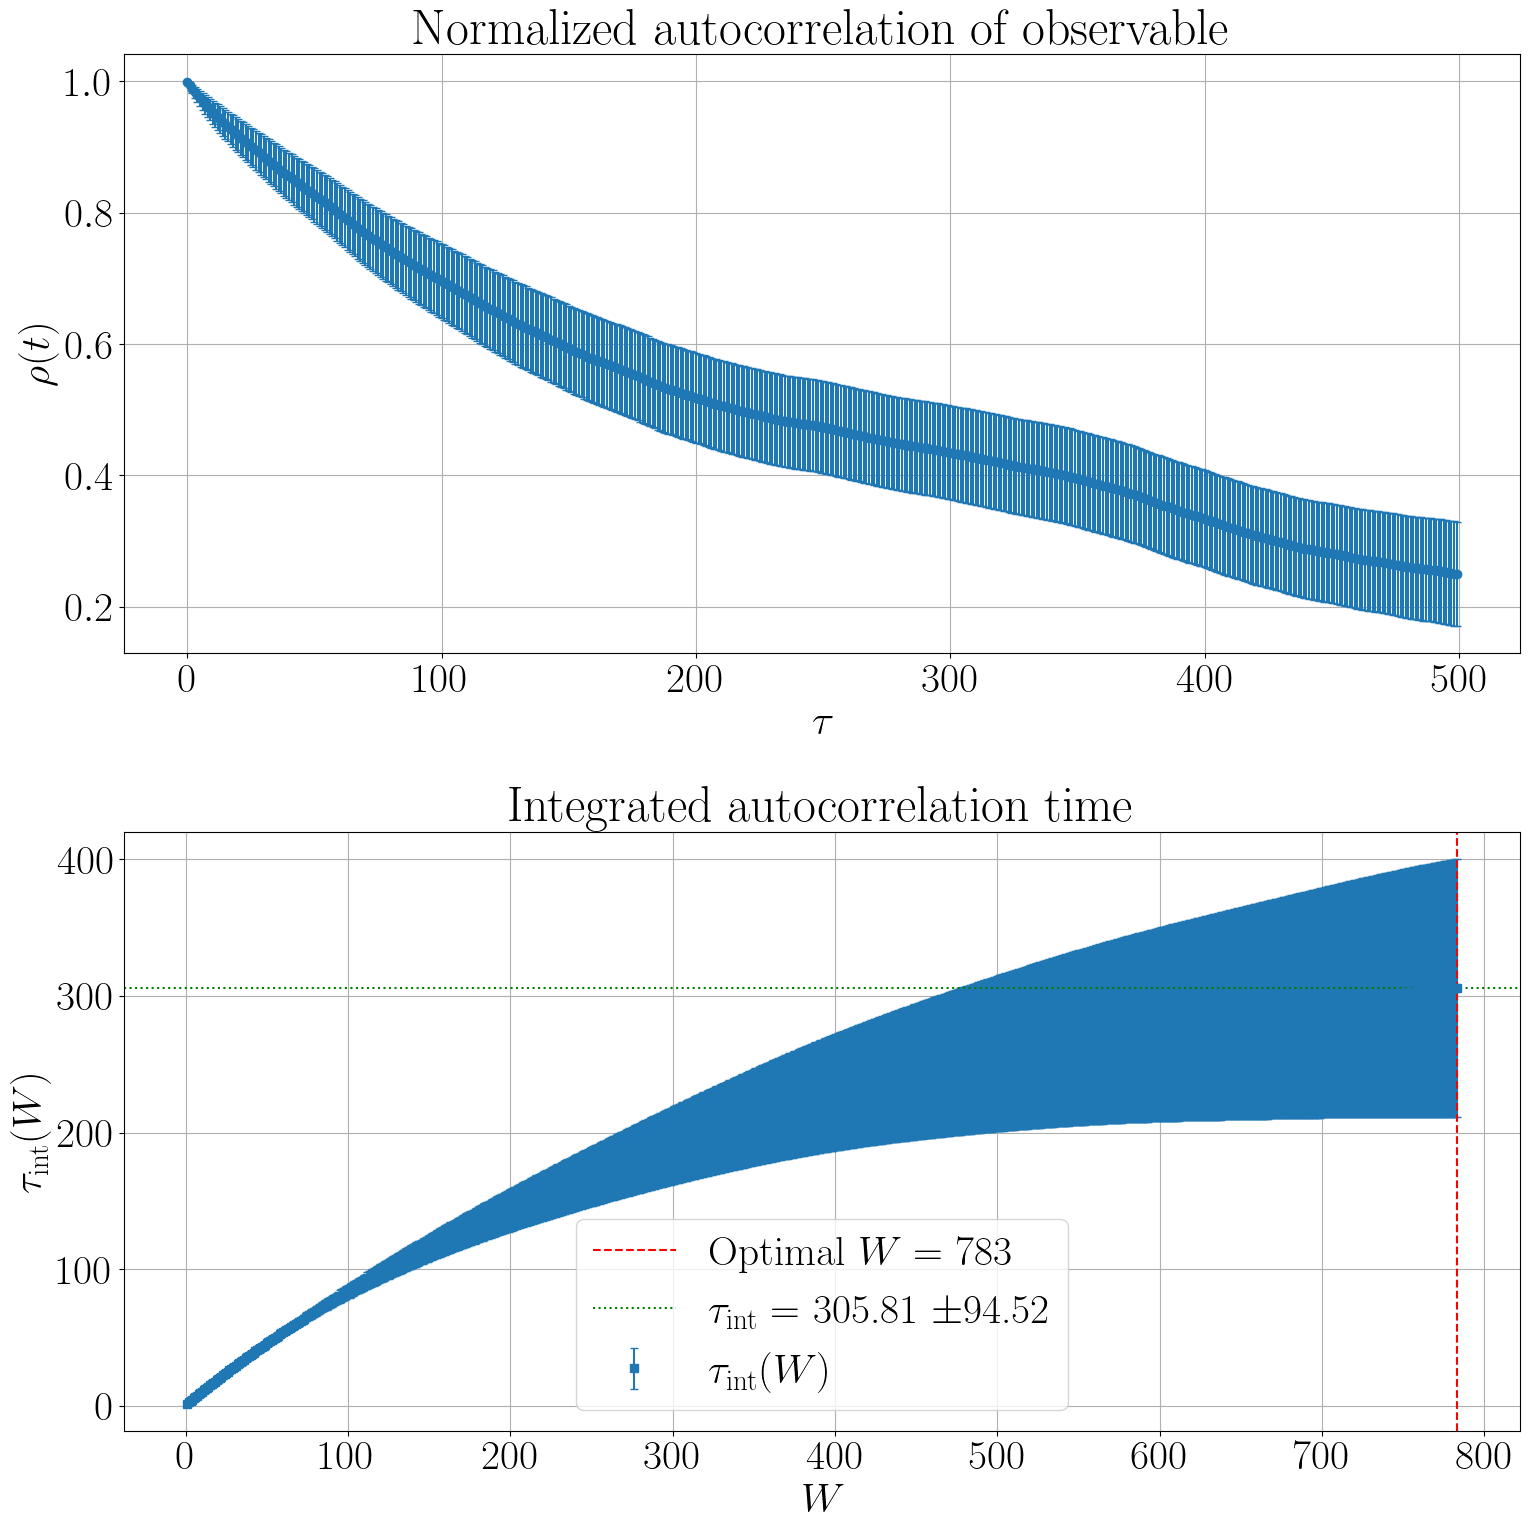

In [21]:
gm.plot_figure_2(results,max_lag=500)

### explore different masses

In [ ]:
mass_grid1=np.linspace(-.585,-0.54,6)
tau_phi1=np.zeros_like(mass_grid1)
tau_suscept1=np.zeros_like(mass_grid1)
dtau_phi1=np.zeros_like(mass_grid1)
dtau_suscept1=np.zeros_like(mass_grid1)
phi_av_mean=np.zeros_like(mass_grid1)
phi_av_std=np.zeros_like(mass_grid1)
sucept_mean=np.zeros_like(mass_grid1)
sucept_std=np.zeros_like(mass_grid1)
sss=0

for mas in mass_grid1:
    L=128
    lat = [L,L]
    # This set of params is very very close to critical.
    lam = 2.4
    #
    Nwarm = 1000
    Nmeas = 10000
    Nskip = 1
    batch_size = 10

    Vol = np.prod(lat)
    sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device)
    phi = sg.hotStart()
    mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
    print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
    hmc = u.hmc(T=sg,I=mn2,verbose=False)

    lC2p, lchi_m, E, av_phi, phi = get_observables_hist(sg, hmc, phi, Nwarm, Nmeas, Nskip)
    #tau_phi1[sss],tau_suscept1[sss] = get_autocorrelationtime(av_phi, lchi_m)
    results_av = gm.gamma_method_with_replicas(gm.split_first_dim_to_list(tr.stack(av_phi).T.unsqueeze(2)), lambda A: A[0], max_lag=2000)
    results_lchi = gm.gamma_method_with_replicas(gm.split_first_dim_to_list(tr.stack(lchi_m).T.unsqueeze(2)), lambda A: A[0], max_lag=2000)
    tau_phi1[sss]=results_av['tau_int']
    tau_suscept1[sss]=results_lchi['tau_int']
    dtau_phi1[sss]=results_av['dtau_int']
    dtau_suscept1[sss]=results_lchi['dtau_int']
    phi_av_mean[sss]=results_av['value']
    phi_av_std[sss]=results_av['dvalue']
    sucept_mean[sss]=results_lchi['value']
    sucept_std[sss]=results_lchi['dvalue']
    print("Gamma results for average phi:")
    print(f"F = {results_av['value']:.6f} ± {results_av['dvalue']:.6f} (±{results_av['ddvalue']:.6f})")
    print(f"tau_int = {results_av['tau_int']:.3f} ± {results_av['dtau_int']:.3f}")
    print(f"W_opt = {results_av['W_opt']}, Q = {results_av['Q']}")
    print("Gamma results for susceptibility:")
    print(f"F = {results_lchi['value']:.6f} ± {results_lchi['dvalue']:.6f} (±{results_lchi['ddvalue']:.6f})")
    print(f"tau_int = {results_lchi['tau_int']:.3f} ± {results_lchi['dtau_int']:.3f}")
    print(f"W_opt = {results_lchi['W_opt']}, Q = {results_lchi['Q']}")
    sss+=1
    #m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi=get_observables(lC2p, lchi_m, E, av_phi, phi)

torch.Size([10, 128, 128]) 16384 tensor(-0.0004) tensor(1.0029)
time 0.0029 micro-seconds per HMC trajecrory
k=  0 (av_phi,chi_m, c2p, E)  -0.00037911406 0.78629816 0.8647147404731472 2.0191133
len(C2p):  10
k=  10 (av_phi,chi_m, c2p, E)  -0.002573313 2.3452122 1.6915237822540732 1.7450216
len(C2p):  10
k=  20 (av_phi,chi_m, c2p, E)  -0.008395276 6.3925557 9.325127743652287 1.5689653
len(C2p):  10
k=  30 (av_phi,chi_m, c2p, E)  -0.0030945528 6.0270004 8.227015305768283 1.3913428
len(C2p):  10
k=  40 (av_phi,chi_m, c2p, E)  -1.5505706e-05 11.215364 6.987836465239849 1.378331
len(C2p):  10
k=  50 (av_phi,chi_m, c2p, E)  0.0039354833 5.7863784 11.692733610230954 1.3748605
len(C2p):  10
k=  60 (av_phi,chi_m, c2p, E)  -0.006667075 13.544554 15.950416621219063 1.2649381
len(C2p):  10
k=  70 (av_phi,chi_m, c2p, E)  -0.022311589 36.942924 16.67057686812383 1.2174352
len(C2p):  10
k=  80 (av_phi,chi_m, c2p, E)  -0.031820994 53.758476 22.0439681689535 1.2122118
len(C2p):  10
k=  90 (av_phi,chi_m

### Relations of meassurements

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1203599/1723070535.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


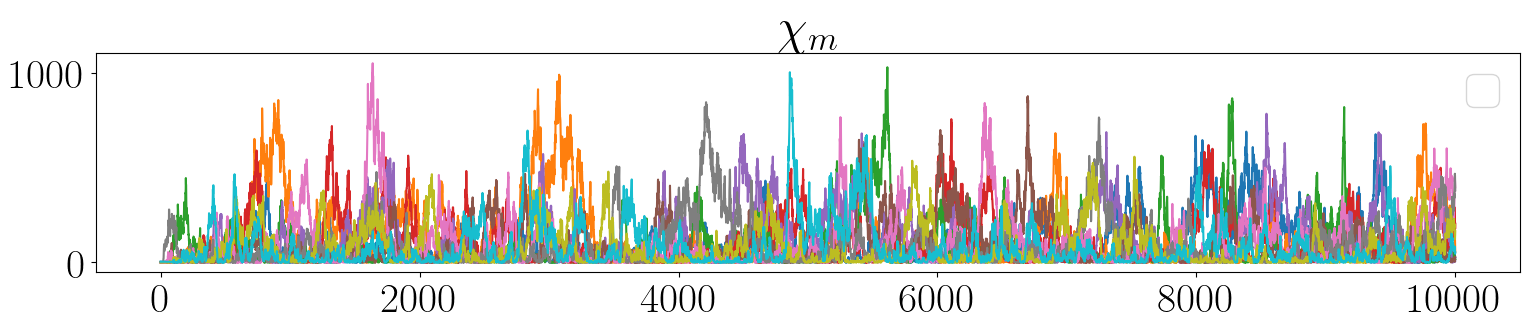

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1203599/1723070535.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


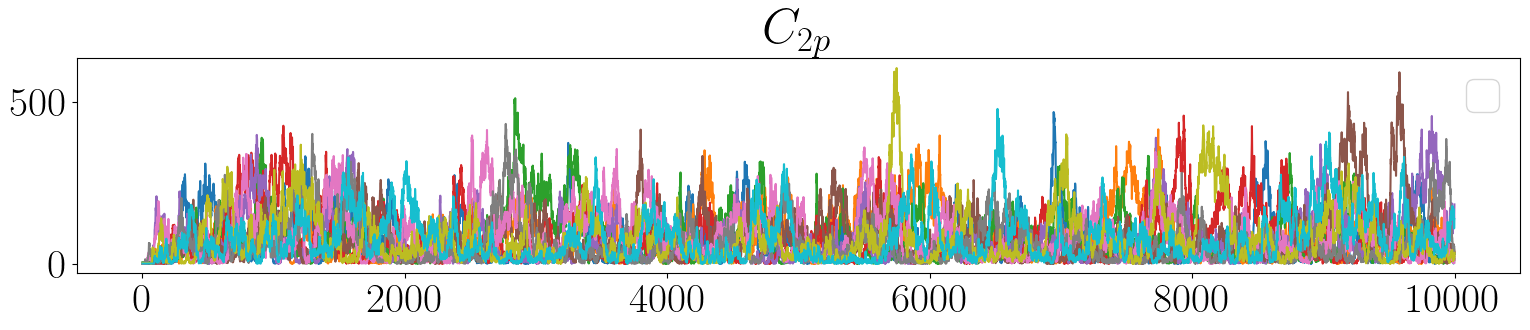

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1203599/1723070535.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


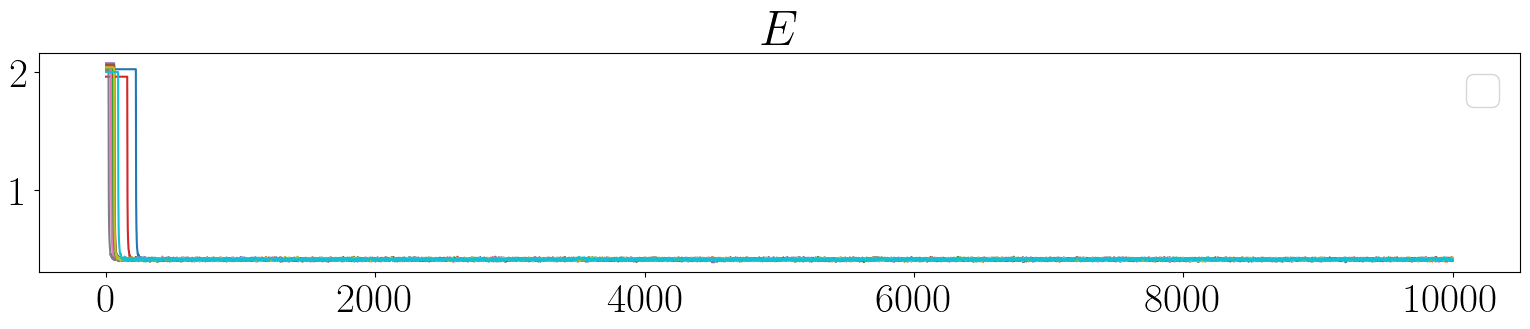

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1203599/1723070535.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


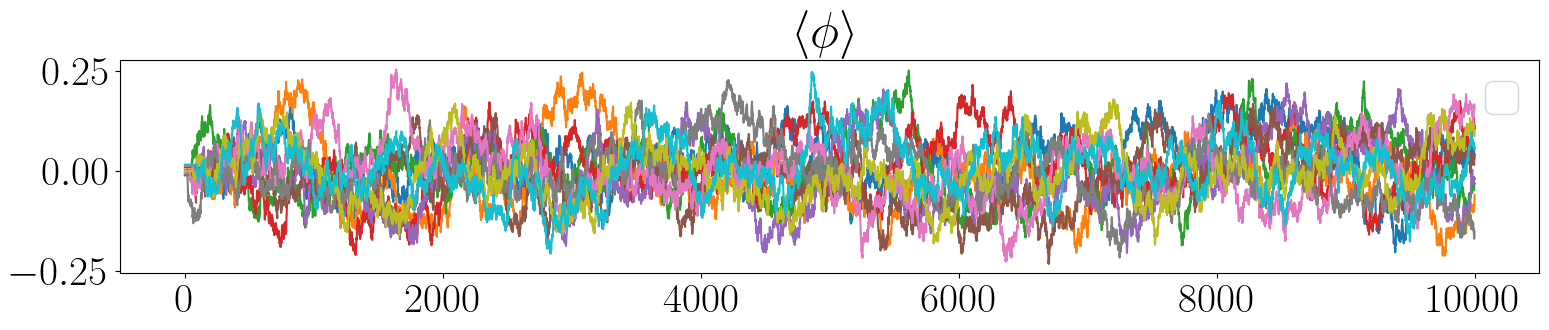

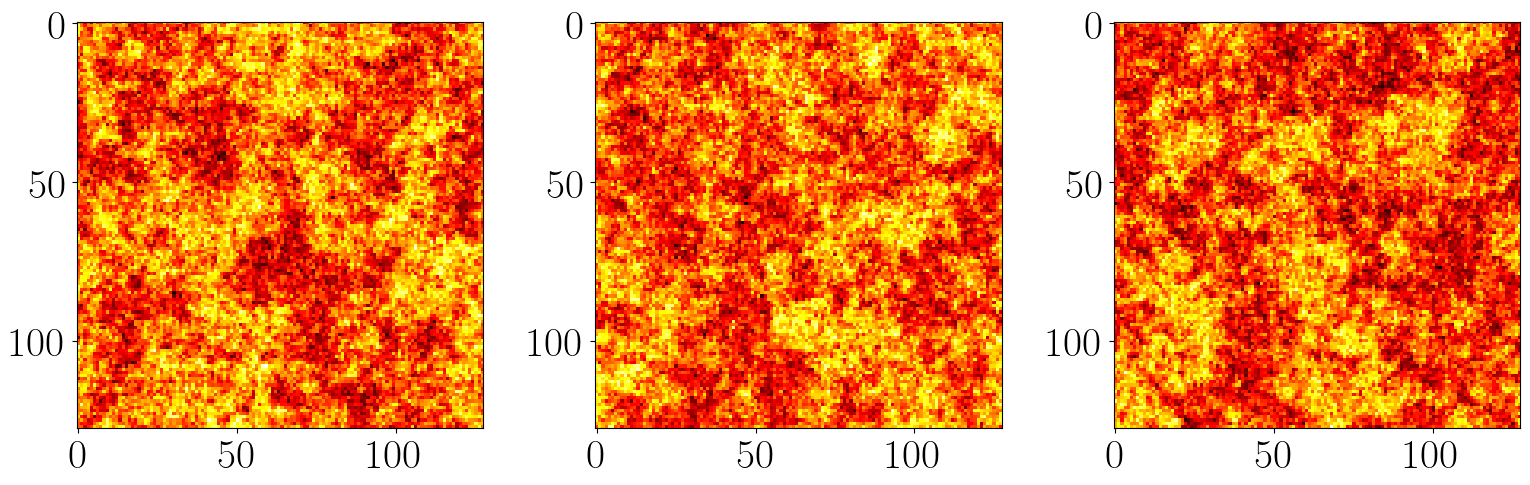

In [32]:

#size of the plot
plt.figure(figsize=(16, 4))
plt.title(r"$\chi_m$")
plt.plot(range(len(lchi_m)),lchi_m)#, label=r'$\chi_m$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$C_{2p}$")
plt.plot(range(len(lC2p)),lC2p)#, label=r'$C_{2p}$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$E$")
plt.plot(range(len(E)),E)#, label=r'$E$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$\langle \phi \rangle$")
plt.plot(range(len(av_phi)),av_phi)#, label=r'$\langle\phi\rangle$')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,3, figsize=(16, 8))
for i in range(0,3):
    ax[i].imshow(phi[i,:,:], cmap='hot', interpolation='nearest')


# Autocorrelation time
Given the formula for autocorrelation time
$$C_X(t) = \frac{1}{(N - t) \cdot \sigma^2} \sum_{i=0}^{N-t-1} (X_i - \bar{X})(X_{i+t} - \bar{X})?$$

torch.Size([3000])
Integrated autocorrelation time for M: 209.80585245698467
Integrated autocorrelation time for chi_m: 164.6775212782384


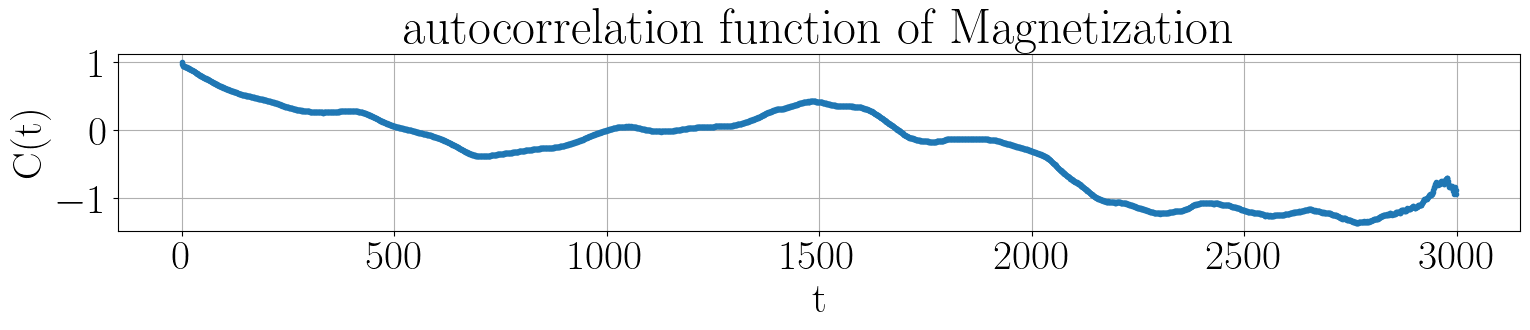

Text(0.5, 0, 't')

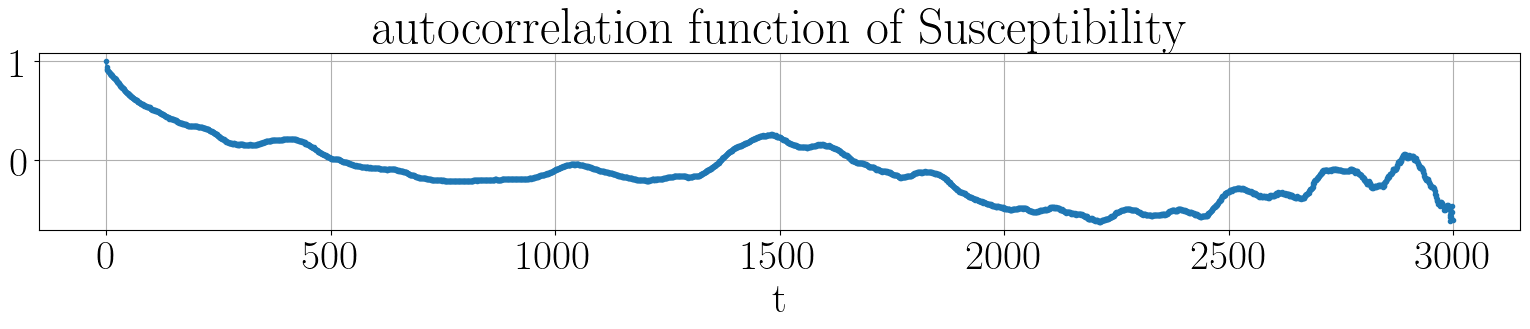

In [ ]:

acf_phi = autocorrelation(tr.tensor(av_phi))
#acf_phi = acf_phi / acf_phi[0]
acf_suscept = autocorrelation(tr.tensor(lchi_m))
print(acf_phi.shape)
tau_int_phi = integrated_autocorrelation_time(acf_phi,600)
tau_int_suscept = integrated_autocorrelation_time(acf_suscept,600)
print(f"Integrated autocorrelation time for M: {tau_int_phi}")
print(f"Integrated autocorrelation time for chi_m: {tau_int_suscept}")

plt.figure(figsize=(16, 4))
plt.plot(acf_phi[:5000], marker='.')
plt.title("autocorrelation function of Magnetization ")
plt.xlabel("t")
plt.ylabel("C(t)")
plt.grid(True)
plt.show()
plt.figure(figsize=(16, 4))
plt.plot(acf_suscept[:5000], marker='.')
plt.title("autocorrelation function of Susceptibility ")
plt.grid(True)
plt.xlabel("t")

# Multigrid

### testing MCMG

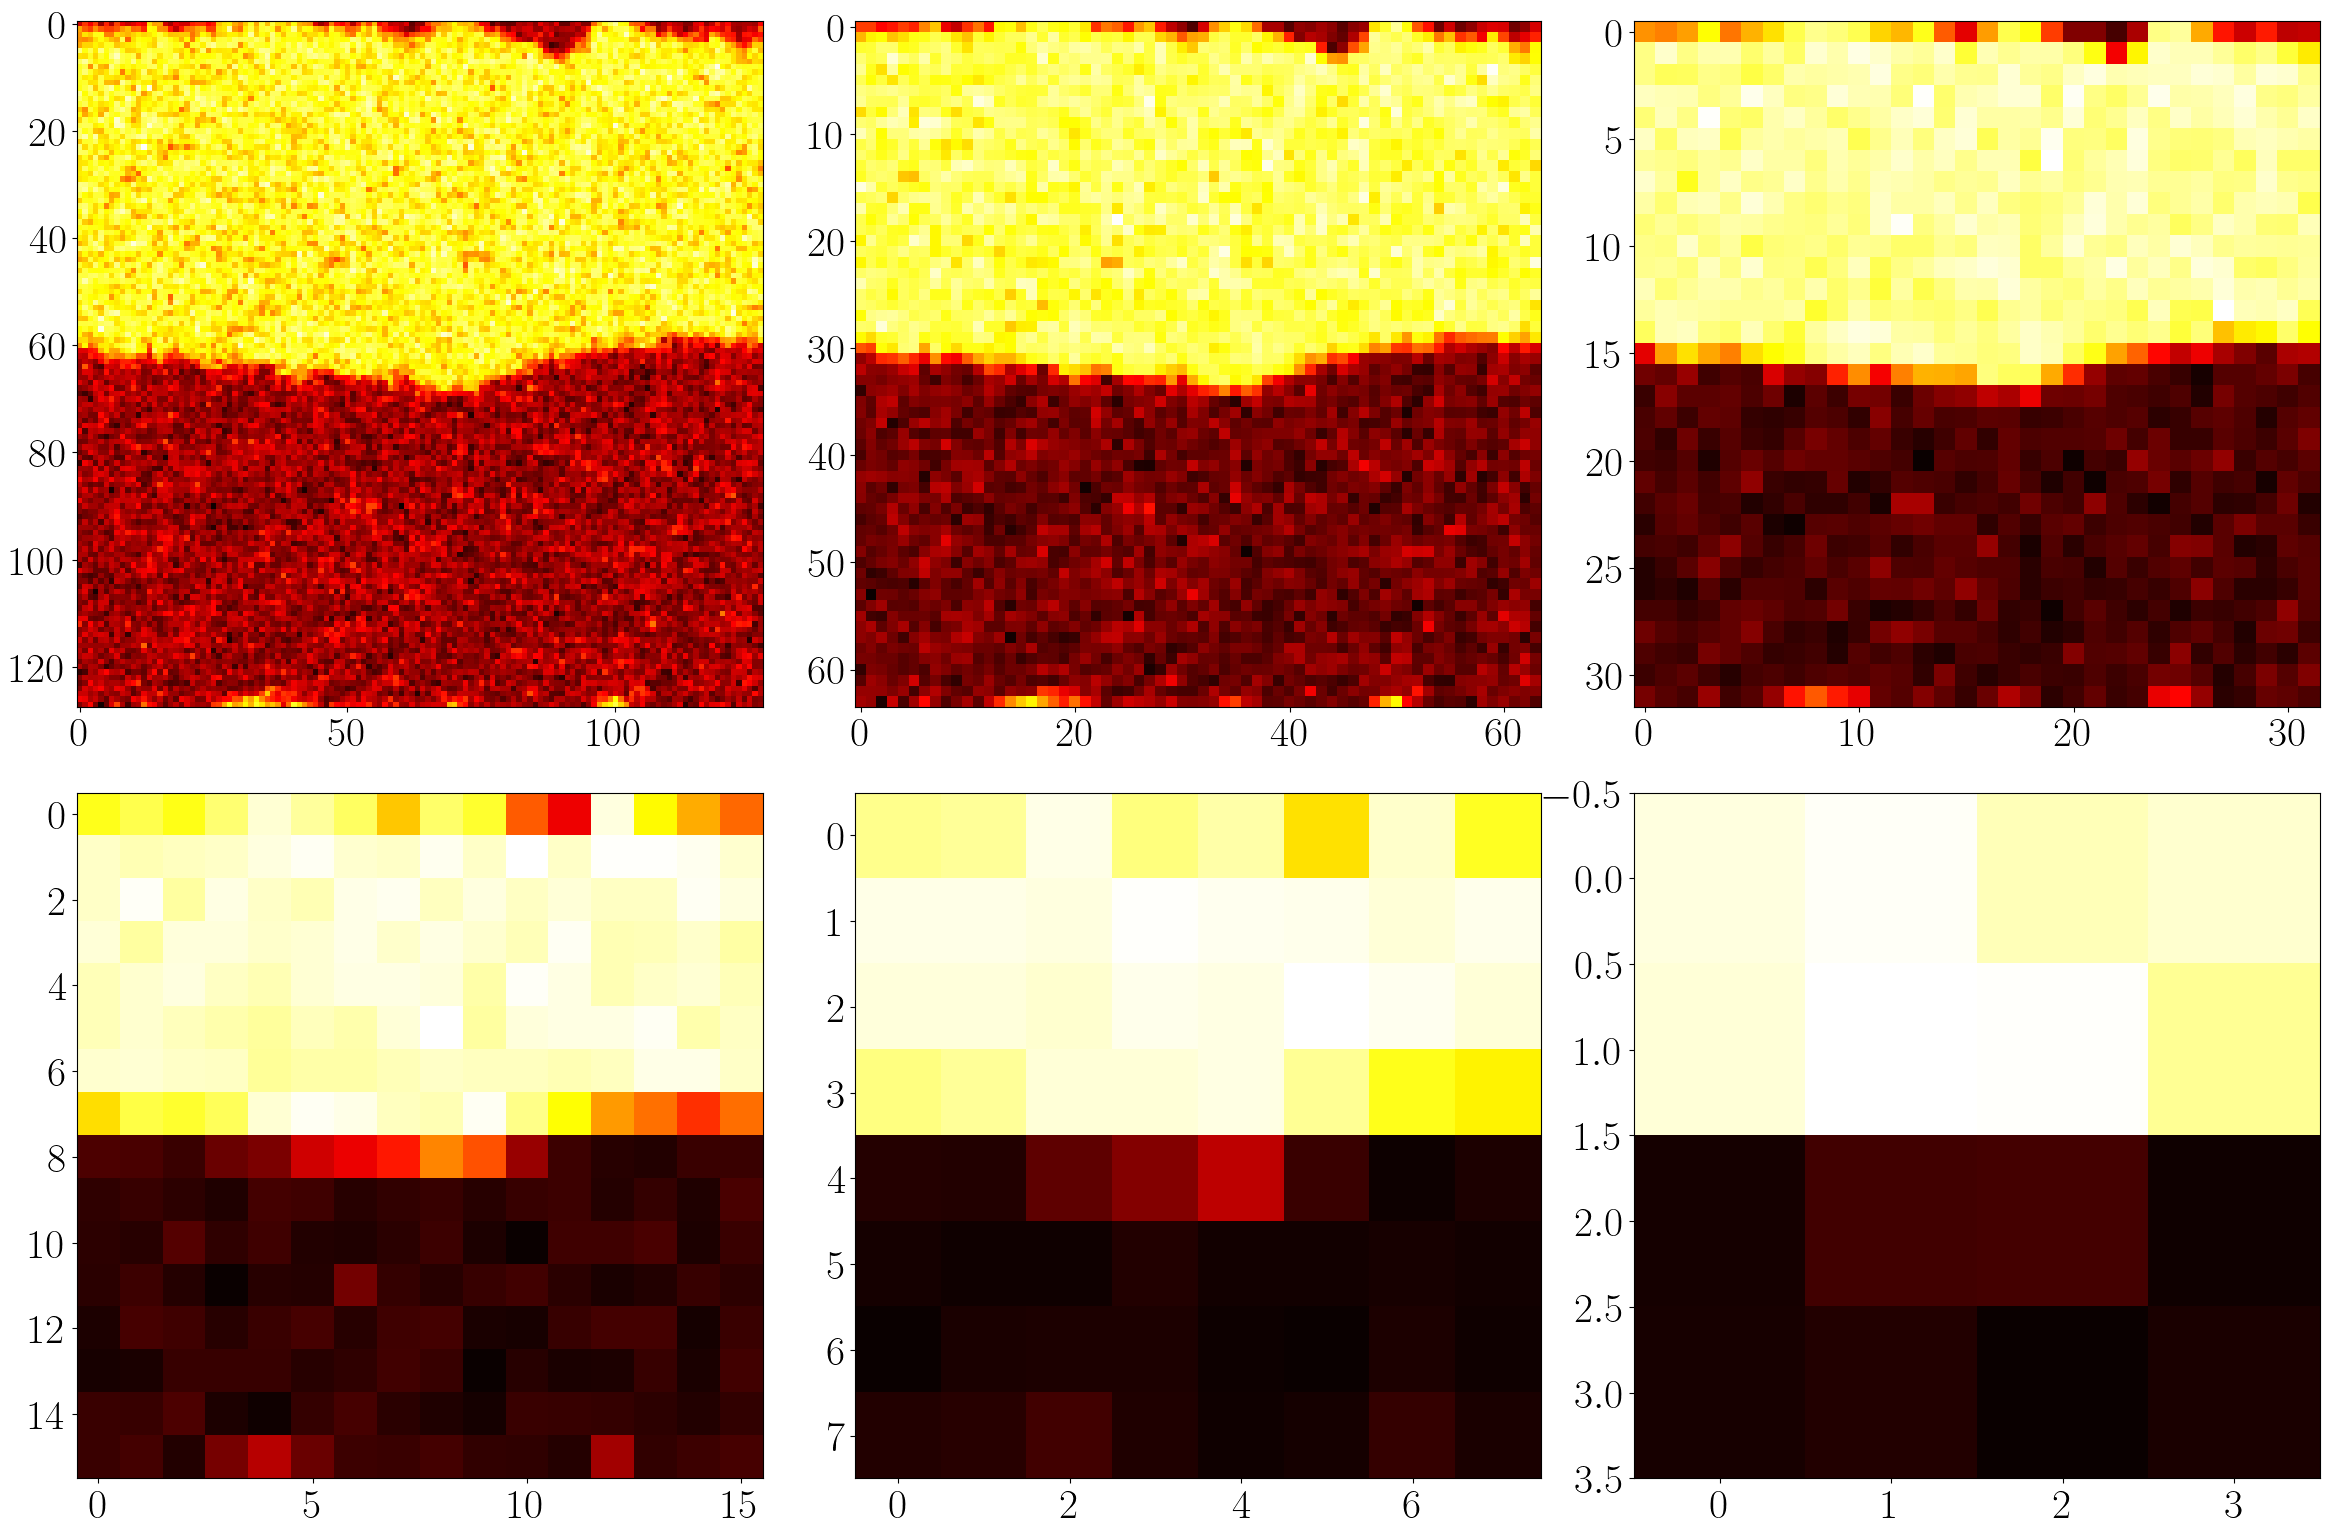

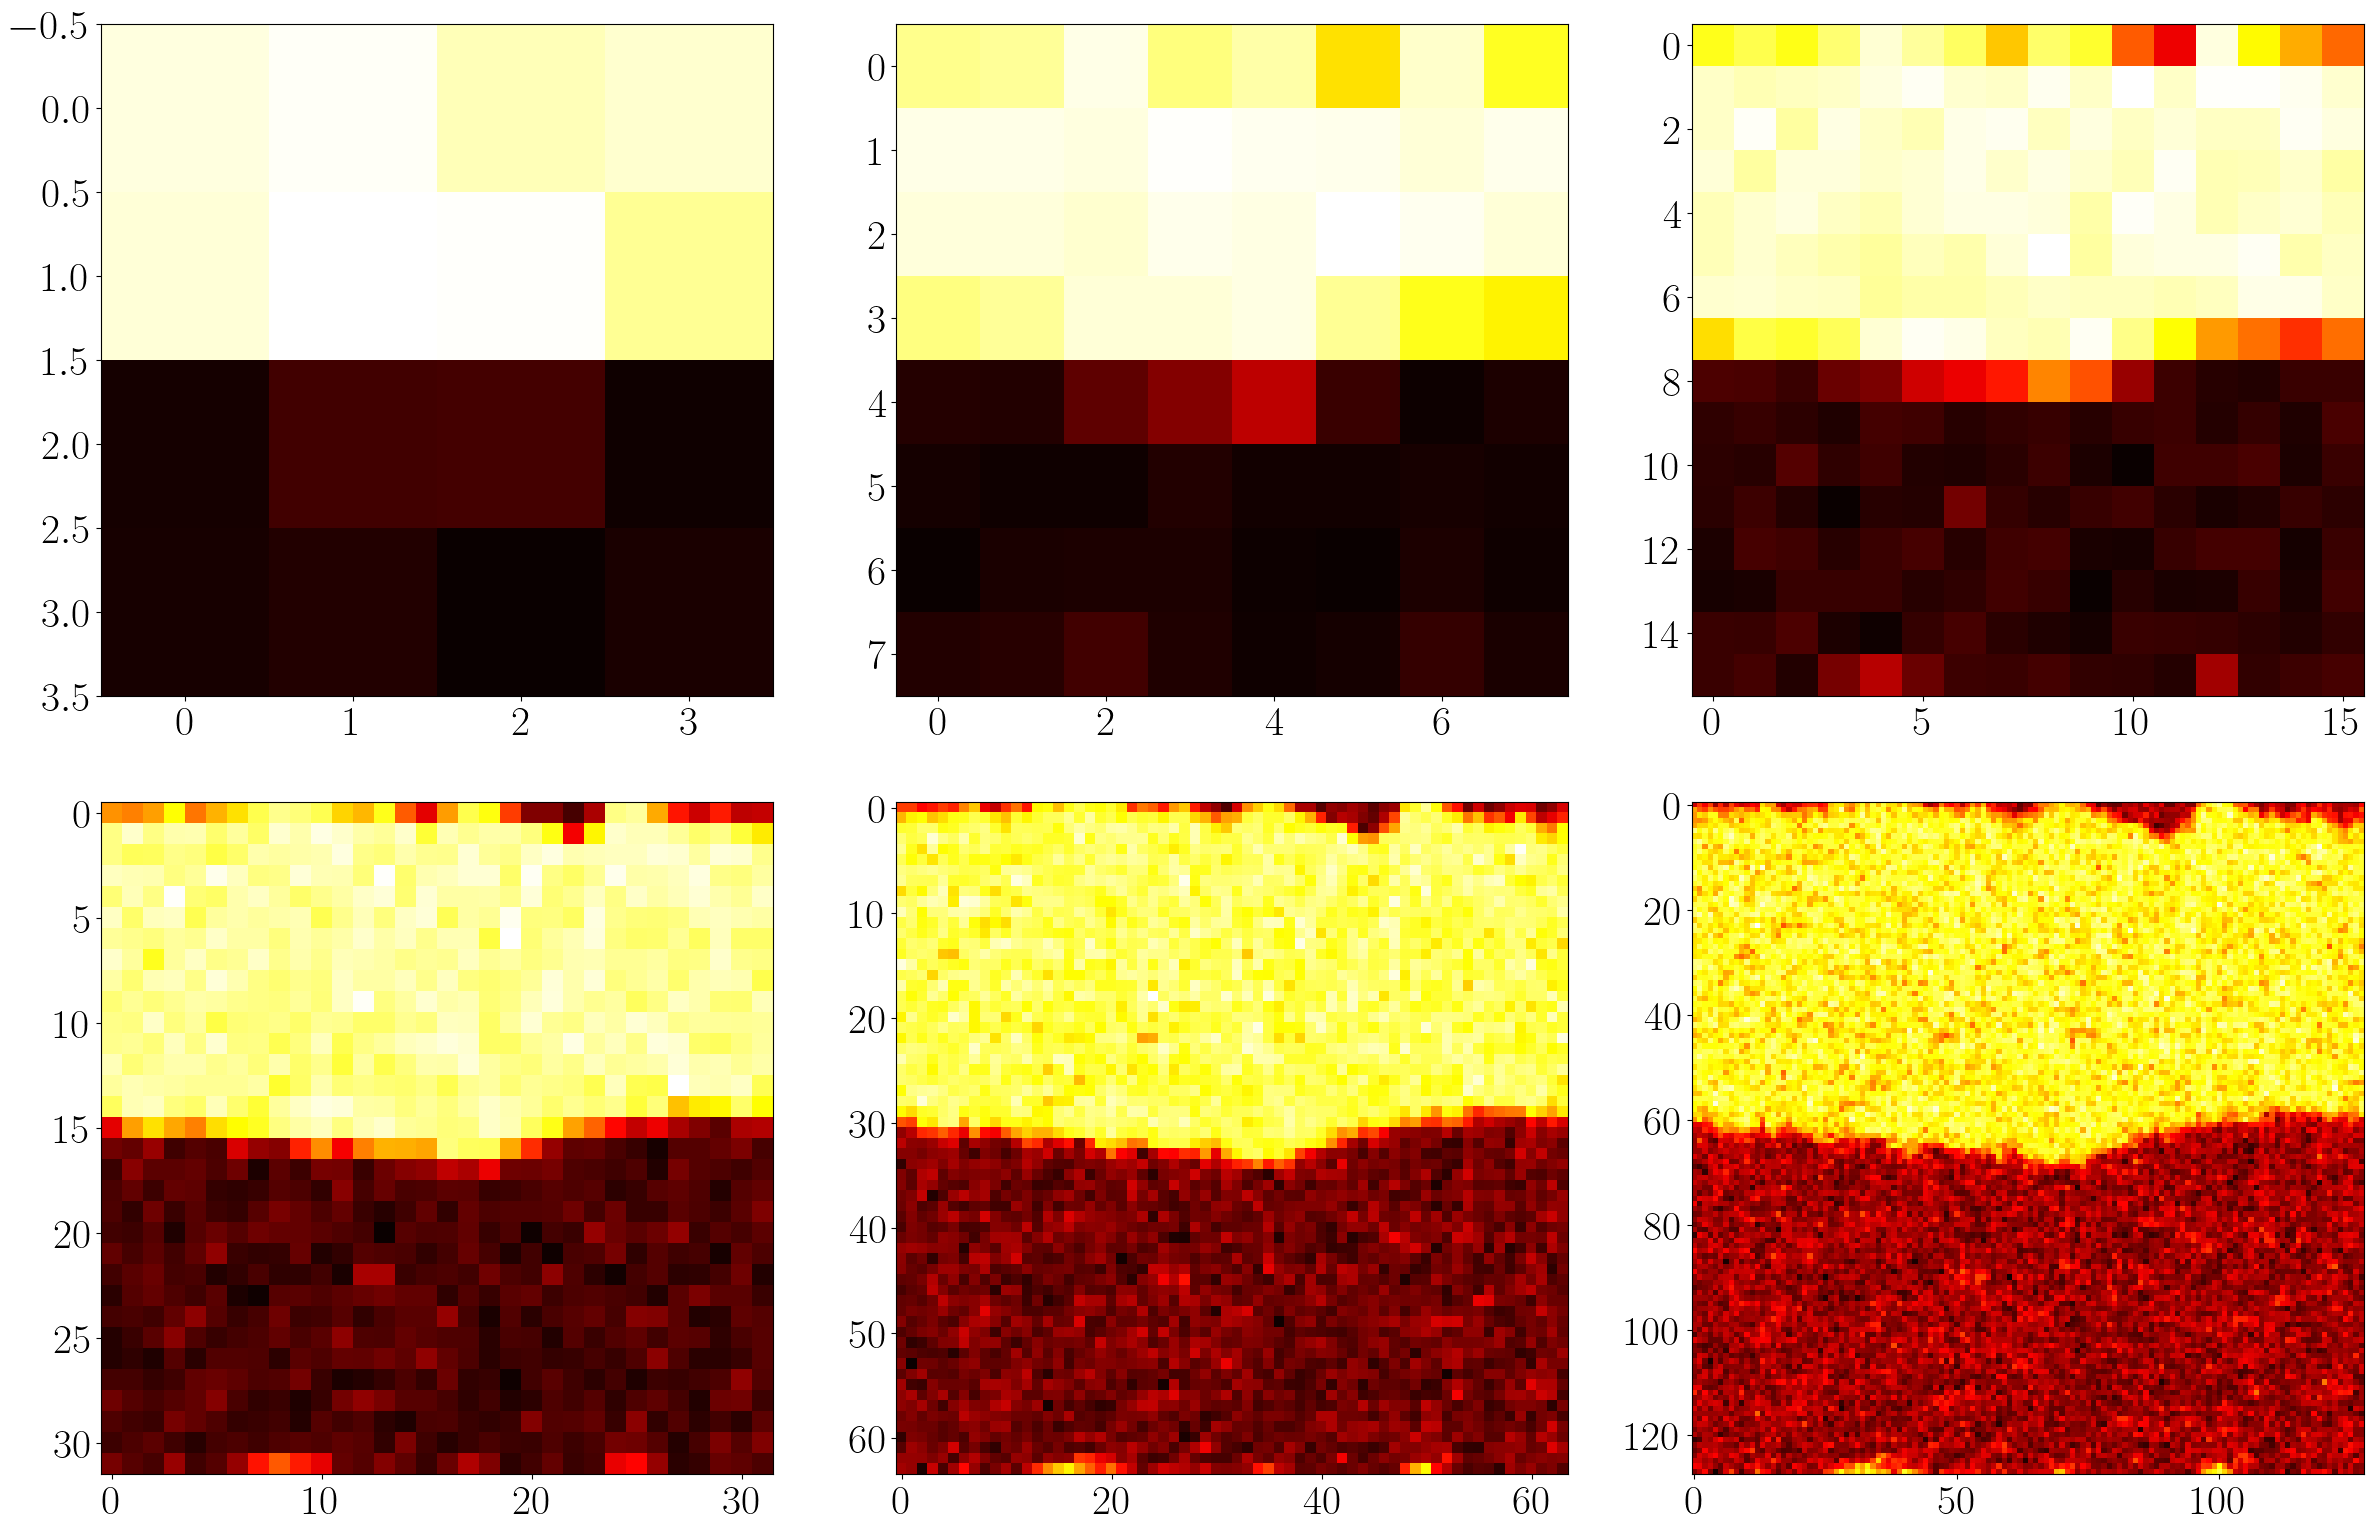

In [53]:
import phi4_mg as phimg
rg = phimg.RGlayer("average")
import integrators as i

phis=[]
pis=[]
phicopy=phi.clone()
phis.append(phi)
for _ in range(5):
    phic,pic = rg.coarsen(phicopy)
    phis.append(phic)
    pis.append(pic)
    phicopy=phic

#reversed
rphis=[]
rphis.append(phis[-1])
iii=0
for pics in reversed(pis):
    rphi = rg.refine(rphis[iii],pics)
    rphis.append(rphi)
    iii+=1

#plot the phi field
fig, ax = plt.subplots(2,3, figsize=(24, 16))
ax[0,0].imshow(phis[0][0,:,:], cmap='hot', interpolation='nearest')
ax[0,1].imshow(phis[1][0,:,:], cmap='hot', interpolation='nearest')
ax[0,2].imshow(phis[2][0,:,:], cmap='hot', interpolation='nearest')
ax[1,0].imshow(phis[3][0,:,:], cmap='hot', interpolation='nearest')
ax[1,1].imshow(phis[4][0,:,:], cmap='hot', interpolation='nearest')
ax[1,2].imshow(phis[5][0,:,:], cmap='hot', interpolation='nearest')
plt.show()
#one level up
fig, ax = plt.subplots(2,3, figsize=(24, 16))
ax[0,0].imshow(rphis[0][0,:,:], cmap='hot', interpolation='nearest')
ax[0,1].imshow(rphis[1][0,:,:], cmap='hot', interpolation='nearest')
ax[0,2].imshow(rphis[2][0,:,:], cmap='hot', interpolation='nearest')
ax[1,0].imshow(rphis[3][0,:,:], cmap='hot', interpolation='nearest')
ax[1,1].imshow(rphis[4][0,:,:], cmap='hot', interpolation='nearest')
ax[1,2].imshow(rphis[5][0,:,:], cmap='hot', interpolation='nearest')
#save figure
plt.savefig("rphis.pdf", bbox_inches='tight',dpi=300)
plt.show()
#one level down 

now we have to update the coarse field, and compare with any of the ml implementation in phi4_mg

### objects definition

In [ ]:
class Rescale(nn.Module):
    def __init__(self, scale=1.0, trainable=True):
        super().__init__()
        self.scale = nn.Parameter(tr.tensor(scale))
        self.scale.requires_grad = trainable
    def forward(self, x):
        return x * self.scale


# to be used to make a realNVP with specific parity properties
class ParityNet(nn.Module):
    def __init__(self, net,Parity=+1):
        super(ParityNet,self).__init__()
        self.Parity = Parity
        self.net = net
    def forward(self,x):
        return 0.5*(self.net(x) + self.Parity*self.net(-x))

def FlowBijectorParity11(Nlayers=3,width=256,ttp=tr.float64,device="cpu"):
    mm = np.array([1,0,0,1])
    tV = mm.size
    nets = lambda: ParityNet(nn.Sequential(nn.Linear(tV, width), nn.Tanh(), nn.Linear(width, width), nn.Tanh(), nn.Linear(width, tV), nn.Tanh(),Rescale(scale=0.001)),Parity=+1).to(device).to(ttp)
    nett = lambda: ParityNet(nn.Sequential(nn.Linear(tV, width), nn.Tanh(), nn.Linear(width, width), nn.Tanh(), nn.Linear(width, tV),Rescale(scale=0.001)),Parity=-1).to(device).to(ttp)

    # the number of masks determines layers
    #Nlayers = 3
    masks = tr.from_numpy(np.array([mm, 1-mm] * Nlayers)).to(device).to(ttp)
    normal = distributions.Normal(tr.zeros(tV,dtype=ttp,device=device),tr.ones(tV,dtype=ttp,device=device))
    prior= distributions.Independent(normal, 1)
    return  RealNVP_1(nets, nett, masks, prior, data_dims=(1,2))

class ZeroNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
    def forward(self, x):
        # Returns zeros matching the input shape
        return x.new_zeros(x.shape)

def init_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


class Cos_nn(nn.Module):
    def forward(self, x):
        return tr.cos(x)

def FlowBijectorParity1(Nlayers=3,width=256,ttp=tr.float64,device="cpu"):
    mm = np.array([1,0,0,1])
    tV = mm.size
    # Use ZeroNet for scaling (Additive Coupling) - LogDet is always 0
    nets = lambda: ZeroNet().to(device).to(ttp)
    # Keep Tanh and Rescale(0.001) for translation
    nett = lambda: ParityNet(nn.Sequential(nn.Linear(tV, width),nn.Tanh(), nn.Linear(width, tV),Rescale(scale=0.0001,trainable=False)),Parity=-1).to(device).to(ttp)
    masks = tr.from_numpy(np.array([mm, 1-mm] * Nlayers)).to(device).to(ttp)
    normal = distributions.Normal(tr.zeros(tV,dtype=ttp,device=device),tr.ones(tV,dtype=ttp,device=device))
    prior= distributions.Independent(normal, 1)
    return  RealNVP_1(nets, nett, masks, prior, data_dims=(1,2))

def FlowBijectorParity_simp1(Nlayers=3,width=256,ttp=tr.float64,device="cpu"):
    mm = np.array([1,0,0,1])
    tV = mm.size
    # Use ZeroNet for scaling (Additive Coupling) - LogDet is always 0
    nets = lambda: ZeroNet().to(device).to(ttp)
    # Keep Tanh and Rescale(0.001) for translation
    nett = lambda: ParityNet(nn.Sequential(nn.Linear(tV, width),nn.Linear(width,tV),nn.Tanh(),Rescale(scale=0.1,trainable=False)),Parity=-1).to(device).to(ttp)
    masks = tr.from_numpy(np.array([mm, 1-mm] * Nlayers)).to(device).to(ttp)
    normal = distributions.Normal(tr.zeros(tV,dtype=ttp,device=device),tr.ones(tV,dtype=ttp,device=device))
    prior= distributions.Independent(normal, 1)
    return  RealNVP_1(nets, nett, masks, prior, data_dims=(1,2))

def FlowBijectorParity_simp2(Nlayers=3,width=256,ttp=tr.float64,device="cpu"):
    mm = np.array([1,0,0,1])
    tV = mm.size
    nets = lambda: ZeroNet().to(device).to(ttp)
    def nett():
        seq = nn.Sequential(nn.Linear(tV,width),nn.Linear(width,tV),nn.Tanh(),Rescale(scale=0.1,trainable=False))
        seq.apply(init_xavier)
        return ParityNet(seq,Parity=-1).to(device).to(ttp)
    masks = tr.from_numpy(np.array([mm, 1-mm] * Nlayers)).to(device).to(ttp)
    normal = distributions.Normal(tr.zeros(tV,dtype=ttp,device=device),tr.ones(tV,dtype=ttp,device=device))
    prior= distributions.Independent(normal, 1)
    return RealNVP_1(nets, nett, masks, prior, data_dims=(1,2))

def FlowBijector_DeepSet(Nlayers=3,width=256,ttp=tr.float64,device="cpu"):
    mm = np.array([1,0,0,1])
    tV = mm.size
    nets = lambda: ZeroNet().to(device).to(ttp)
    def nett():
        seq = nn.Sequential(nn.Linear(tV,width),nn.Linear(width,tV),nn.Tanh(),Rescale(scale=0.1,trainable=False))
        seq.apply(init_xavier)
        return seq.to(device).to(ttp)
    masks = tr.from_numpy(np.array([mm, 1-mm] * Nlayers)).to(device).to(ttp)
    normal = distributions.Normal(tr.zeros(tV,dtype=ttp,device=device),tr.ones(tV,dtype=ttp,device=device))
    prior= distributions.Independent(normal, 1)
    return RealNVP_1(nets, nett, masks, prior, data_dims=(1,2))

def FlowBijector_rnvp(Nlayers=3,width=256,ttp=tr.float64,device="cpu"):
    mm = np.array([1,0,0,1])
    tV = mm.size
    #nets = lambda: ZeroNet().to(device).to(ttp)
    def nets():
        seq = nn.Sequential(nn.Linear(tV,width),nn.Linear(width,tV),Cos_nn(),Rescale(scale=0.1,trainable=False))
        seq.apply(init_xavier)
        return seq.to(device).to(ttp)
    def nett():
        seq = nn.Sequential(nn.Linear(tV,width),nn.Linear(width,tV),nn.Tanh(),Rescale(scale=0.1,trainable=False))
        seq.apply(init_xavier)
        return seq.to(device).to(ttp)
    masks = tr.from_numpy(np.array([mm, 1-mm] * Nlayers)).to(device).to(ttp)
    normal = distributions.Normal(tr.zeros(tV,dtype=ttp,device=device),tr.ones(tV,dtype=ttp,device=device))
    prior= distributions.Independent(normal, 1)
    return RealNVP_1(nets, nett, masks, prior, data_dims=(1,2))

# Identity Bijector for Debugging
class IdentityFlow(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        
    def g(self, z):
        # Forward: z -> x. Returns x, log_det (B,)
        return z, z.new_zeros(z.shape[0])

    def f(self, x):
        # Backward: x -> z. Returns z, log_det (B,)
        return x, x.new_zeros(x.shape[0]) 

def FlowBijectorParity2(Nlayers=3,width=256,ttp=tr.float64,device="cpu"):
    # RETURNING IDENTITY FLOW TO DEBUG STABILITY
    return IdentityFlow()



class RealNVP_1(nn.Module):
    def __init__(self, nets, nett, mask, prior,data_dims=(1)):
        super(RealNVP_1, self).__init__()
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = tr.nn.ModuleList([nett() for _ in range(len(mask))])
        self.s = tr.nn.ModuleList([nets() for _ in range(len(mask))])
        self.data_dims=data_dims
        
    # this is the forward start from noise target
    def g(self, z):
        log_det_J_for, x = z.new_zeros(z.shape[0]), z

        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * tr.exp(s) + t)
            log_det_J_for += s.sum(dim=self.data_dims)
        return x, log_det_J_for
    
    # this is backward from target to noise
    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * tr.exp(-s) + z_
            log_det_J -= s.sum(dim=self.data_dims)
        return z, log_det_J

    def forward(self,z):
        return self.g(z)
    
    def backward(self,x):
        return self.f(x)
    
    def log_probf(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp #+ self.C
    
    def log_probg(self,z):
        x, logp = self.g(z)
        return self.prior.log_prob(z) - logp
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        #logp = self.prior.log_prob(z)
        x = self.g(z)
        return x



### test the field transformation

### epsilon test

In [18]:

def epsilon_test(sg,mgf,sgc,phi):
    print("Initializing epsilon test")
    eps1=[]
    deltaH=[]
    mgf.eval()

    sgc.generate_cfg_levels(phi)
    phic,logdet=mgf.backward(phi)
    Pc=sgc.refreshP()

    K=sgc.kinetic(Pc)
    V=sgc.action(phic)
    Hinit=K+V
    print("initial energy",Hinit)

    for rk in np.geomspace(20,120,20):
        k=int(rk)
        dt=1.0/k
        print("we are in the",k,"step")
        mn2c = integ.minnorm2(sgc.force,sgc.evolveQ,k,1.0)
        Pc2,phic2= mn2c.integrate(Pc,phic)
        
        
        Hfinal=sgc.kinetic(Pc2)+sgc.action(phic2)
        DH=tr.abs(Hfinal-Hinit)
        eps1.append(dt)
        deltaH.append(DH)


    DelH=tr.stack(deltaH).to("cpu")
    e=tr.tensor(eps1).to("cpu")

    return e,DelH

eps,delH=epsilon_test(sg,mgf,sgc,phi)

Initializing epsilon test
initial energy tensor([391.2284, 369.5890, 337.9474, 395.7271, 447.1459, 414.8265, 483.1666,
        328.9284, 425.0469, 382.1162, 393.8504, 364.9953, 404.3333, 416.6694,
        542.5976, 402.6090, 454.9865, 489.9409, 431.6177, 345.5067, 357.3857,
        302.7007, 405.4277, 427.1672, 425.3102, 371.5144, 439.3562, 352.3304,
        396.1364, 438.1378, 324.0378, 341.4318, 432.6146, 383.4467, 448.4333,
        341.1802, 331.6657, 409.2271, 442.0377, 497.4919, 355.6670, 341.6802,
        432.3541, 411.9485, 457.7523, 496.0838, 351.1390, 540.3223, 382.9254,
        407.8562, 454.4960, 358.2923, 312.5102, 414.6645, 508.7259, 422.7351,
        568.6551, 411.8410, 350.9907, 423.8255, 452.4772, 395.4943, 415.6577,
        448.3960, 380.6723, 385.7794, 458.5059, 359.1424, 427.1009, 464.6277,
        435.1569, 364.2274, 366.5691, 381.1497, 483.6846, 389.9333, 428.4977,
        370.4357, 442.9536, 466.6034, 413.2449, 491.4066, 328.9529, 413.1742,
        323.8525, 389.5

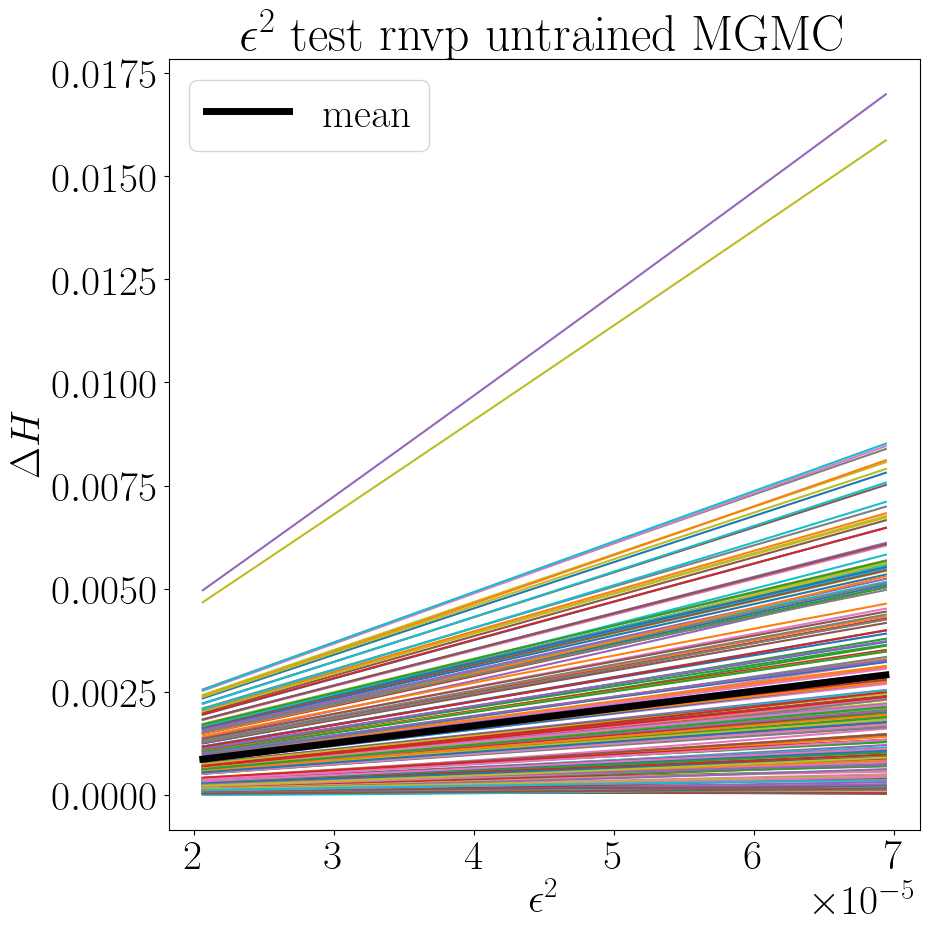

In [16]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_xlabel(r"$\epsilon^2$")
ax.set_ylabel(r"$\Delta H$")
ax.set_title(r"$\epsilon^2$ test rnvp untrained MGMC")
for i in range(delH.shape[1]):
    ax.plot(eps*eps,delH[:,i].detach().numpy())
#mean of batch
#plot with a thick black line
ax.plot(eps*eps,delH.mean(dim=1).detach().numpy(), 'k',linewidth=5, label="mean")
#limits in y
#ax.set_ylim([0.00,0.0121])
#set log scale y
ax.legend()

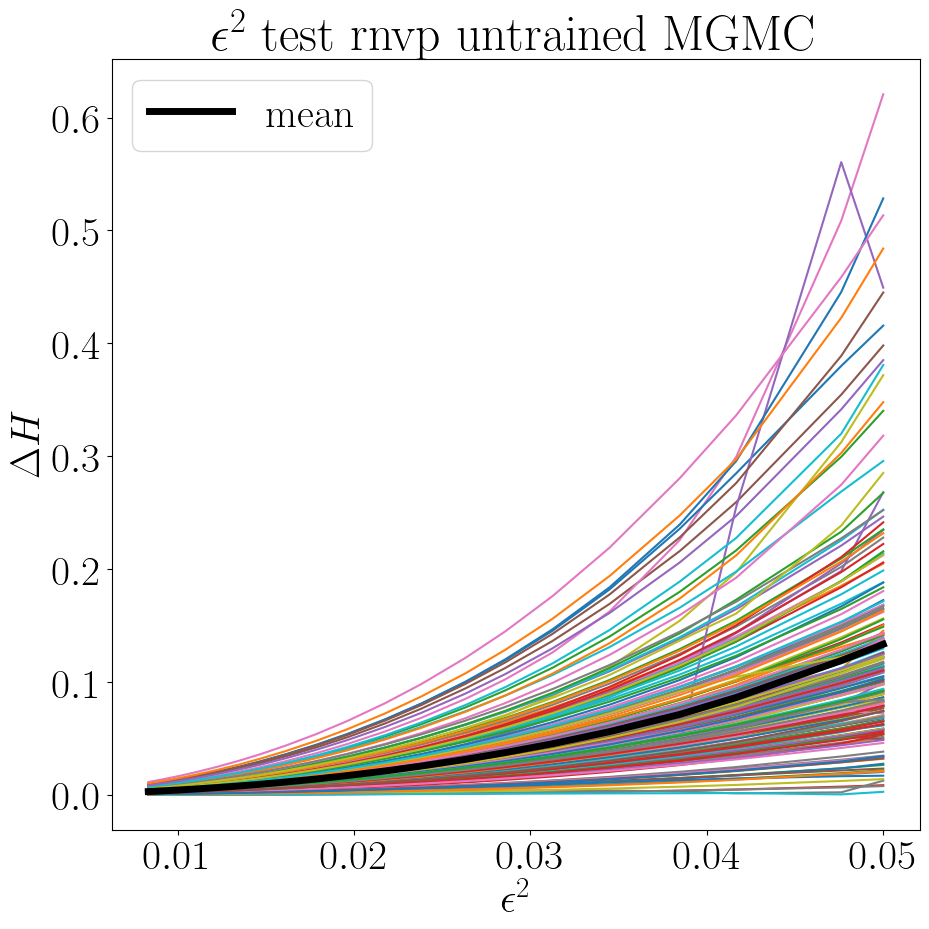

In [20]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_xlabel(r"$\epsilon^2$")
ax.set_ylabel(r"$\Delta H$")
ax.set_title(r"$\epsilon^2$ test rnvp untrained MGMC")
for i in range(delH.shape[1]):
    ax.plot(eps,delH[:,i].detach().numpy())
#mean of batch
#plot with a thick black line
ax.plot(eps,delH.mean(dim=1).detach().numpy(), 'k',linewidth=5, label="mean")
#limits in y
#ax.set_ylim([0.00,0.0121])
#set log scale y
ax.legend()

In [ ]:


import integrators as integ
#list
eps1=[]
deltaH=[]

mgf.eval()

phi= hmc.evolve(phi,1)
sgc = phi4_c1(sg,mgf,device=sg.device,dtype=sg.dtype,mode="rnvp")
#print(phi.view(phi.shape[0], 1, phi.shape[1], phi.shape[2]).shape)
#print("phi",phi.shape)
sgc.generate_cfg_levels(phi)


phic,logdet=mgf.backward(phi)
Pc=sgc.refreshP()

K=sgc.kinetic(Pc)
V=sgc.action(phic)
Hinit=K+V
print("initial energy",Hinit)

for rk in np.geomspace(20,120,20):
    k=int(rk)
    dt=1.0/k
    print("we are in the",k,"step")
    mn2c = integ.minnorm2(sgc.force,sgc.evolveQ,k,1.0)
    Pc2,phic2= mn2c.integrate(Pc,phic)
    
    
    Hfinal=sgc.kinetic(Pc2)+sgc.action(phic2)
    DH=tr.abs(Hfinal-Hinit)
    eps1.append(dt)
    deltaH.append(DH)
    #hmcc = u.hmc(T=sgc,I=mn2c,verbose=True)
    
    #phic_up=hmcc.evolve(phic,1)
    #now go back up
    #for sss in reversed(range(mgf.depth)):
        #phic_up= mgf.rg.refine(phic_up,sgc.pics[sss])

    
    #print("shape of fine field ",phic_up.shape)
    #phic_up=hmc.evolve(phic_up,1)

DelH=tr.stack(deltaH).to("cpu")
e=tr.tensor(eps1).to("cpu")


multigrid is done by:  rnvp
initial energy tensor([ -32.8862,  -34.4131,  -14.2789,  -69.0820, -103.1782, -117.3815,
         -95.1130,  -63.8994,  -81.7593, -127.2683,  -90.1607,  -25.3291,
         -78.6110, -121.4567,  -57.0273,  -30.0253,  -90.4931,  -96.9002,
         -66.8180,  -78.9843,  -88.7787,  -36.4285,  -29.5148,  -47.4498,
        -108.8101,  -87.4956,  -20.6422,  -47.5477,  -68.0128,  -74.4440,
         -37.1558, -109.7694,  -80.0457,  -77.5758,   -7.2363,  -91.9896,
         -95.1886, -115.4488,  -32.2568,  -31.0588,  -74.7067,  -50.7708,
         -57.8597,  -61.2421,  -36.1982,  -21.6792,  -90.6376,  -17.5168,
         -59.1448,   -6.4054,  -75.9097,  -25.8471,  -67.0610,    2.9557,
         -87.9762,  -31.1708,  -69.9659,  -47.8192,  -95.1107,  -46.1736,
         -46.2436,  -19.5695,  -15.9927, -100.2526, -140.4515,  -11.5600,
         -28.6495,  -28.1211,  -76.3327,  -28.9186,  -74.5964,  -58.6171,
         -56.1596,  -68.6021,  -87.0606,  -79.8701,  -76.3356,  -79.9

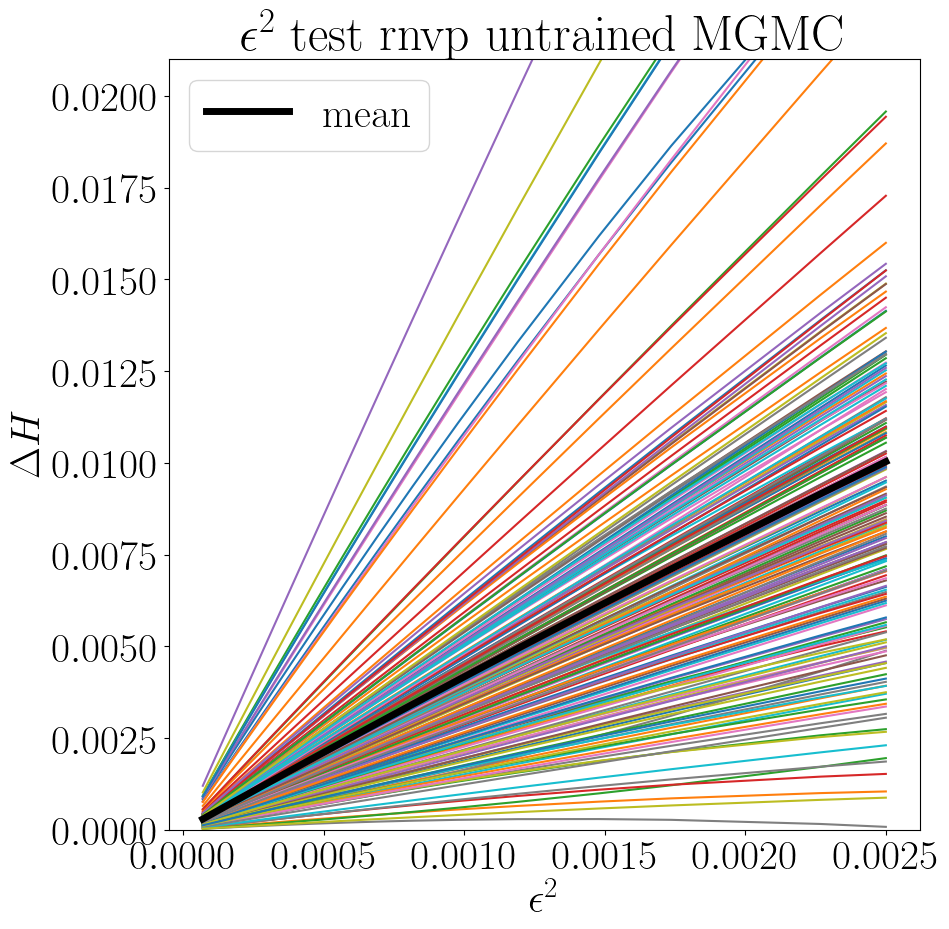

In [53]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_xlabel(r"$\epsilon^2$")
ax.set_ylabel(r"$\Delta H$")
ax.set_title(r"$\epsilon^2$ test rnvp untrained MGMC")
for i in range(DelH.shape[1]):
    ax.plot(e*e,DelH[:,i].detach().numpy())
#mean of batch
#plot with a thick black line
ax.plot(e*e,DelH.mean(dim=1).detach().numpy(), 'k',linewidth=5, label="mean")
#limits in y
ax.set_ylim([0.00,0.021])
#set log scale y
ax.legend()

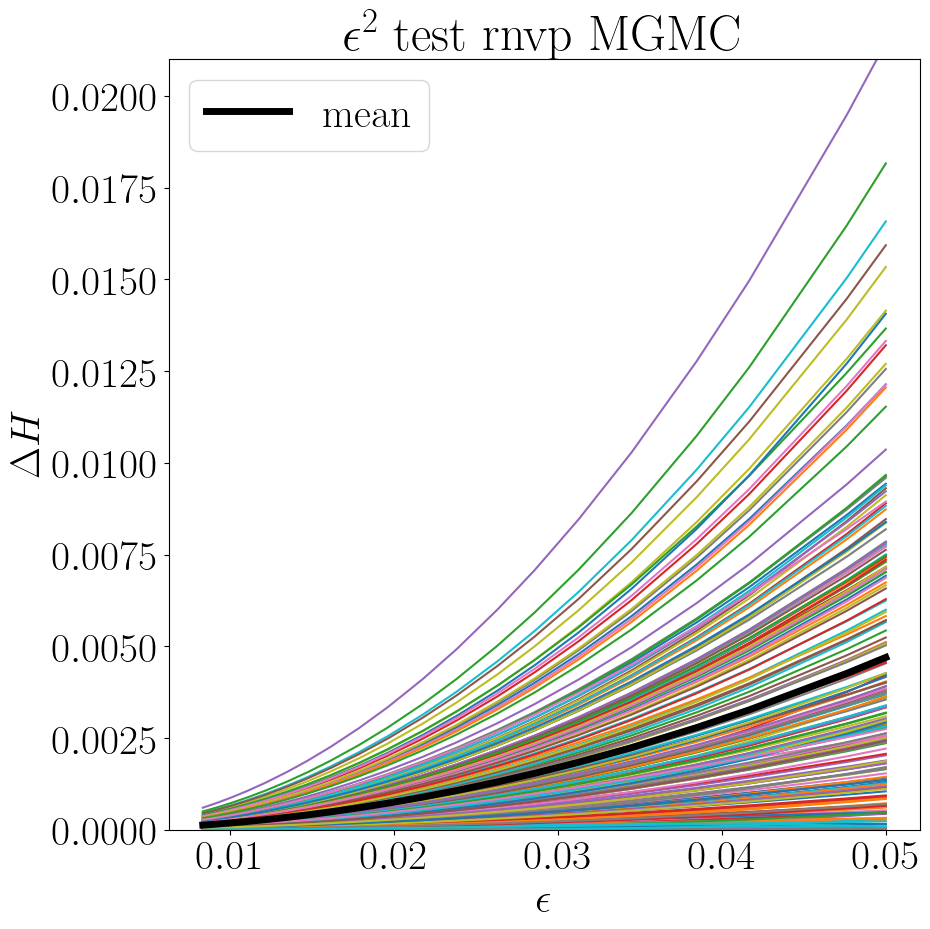

In [42]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_xlabel(r"$\epsilon$")
ax.set_ylabel(r"$\Delta H$")
ax.set_title(r"$\epsilon^2$ test rnvp MGMC")
for i in range(DelH.shape[1]):
    ax.plot(e,DelH[:,i].detach().numpy())
#mean of batch
#plot with a thick black line
ax.plot(e,DelH.mean(dim=1).detach().numpy(), 'k',linewidth=5, label="mean")
#limits in y
ax.set_ylim([0.00,0.021])
#set log scale y
ax.legend()

### Train

#### KL divergence 

In [ ]:
loss_history = []
super_batch_size = 100
for t in range(1001):   
    #with torch.no_grad():
    #z = prior.sample((batch_size,1)).squeeze().reshape(batch_size,L,L)
    z = mgf.prior_sample(batch_size)
    #print(z.shape,z.device)
    x = mgf(z) # generate a sample
    #print(x.shape,x.device)
    tloss = (mgf.log_prob(x)+sg.action(x))
    for b in range(1,super_batch_size):
        z = mgf.prior_sample(batch_size)
        x = mgf(z) # generate a sample
        tloss += (mgf.log_prob(x)+sg.action(x)) # KL divergence (or not?)
    loss =tloss.mean()/super_batch_size

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    loss_history.append(loss.cpu().detach().numpy())
    #print(loss_history[-1])
    if t % 50 == 0:
        #print(z.shape)
        print('iter %s:' % t, 'loss = %.3f' % loss)

In [30]:
def train_multigrid_KL(mgf,phi,sgc,steps=1001):
    # Optimizador
    optimizer = tr.optim.Adam([p for p in mgf.parameters() if p.requires_grad], lr=1e-3,weight_decay=1e-4)
    scheduler = tr.optim.lr_scheduler.OneCycleLR(optimizer, steps_per_epoch=1,pct_start=0.1,anneal_strategy='cos',div_factor=25,max_lr=1e-2,epochs=steps)
    loss_history = []

    # Configuraciones
    super_batch_size = 10 # Si lo usas para acumular gradientes
    mgf.train() # IMPORTANTE: Activa dropouts o batchnorms si los hubiera
    with tr.no_grad():
        mgf.generate_levels(phi)


    print("Iniciando entrenamiento...")

    for t in range(steps):   
        optimizer.zero_grad() # Limpiamos gradientes ANTES del super-batch
        
        # Beta Annealing: De 5.0 (fuerza la energía) a 1.0 (física real) en 800 épocas
        #progreso = min(1.0, t / 800.0)
        #beta = 5.0 * (1 - progreso) + 1.0 * progreso
        
        batch_loss_acum = 0
        
        # Opción A: Acumulación de Gradientes (Ahorra memoria RAM)
        for b in range(super_batch_size):
            # 1. Muestrear z
            phi_c=mgf.backward(phi)### I have to change the prior sample function for coarse level!!!!!
            z = mgf.prior_sample_coarse(batch_size)
            # 2. Forward eficiente (Obtenemos x y el LogDet en UNA pasada)
            # NO llamamos a mgf.log_prob(x) después.
            x, log_det_J = mgf.forward(z) 
            
            # 3. Calcular log q(x)
            # Obtenemos la probabilidad cruda
            z_flat = z.flatten(start_dim=1)
            raw_lp = mgf.prior.log_prob(z_flat)

            # Verificamos si necesitamos sumar dimensiones
            if raw_lp.dim() > 1:
                log_p_z = raw_lp.sum(dim=1) # Caso Normal(0,1) estándar
            else:
                log_p_z = raw_lp            # Caso MultivariateNormal (ya viene sumado)
            
            # Ahora sí calculamos log q(x)
            log_q_x = log_p_z - log_det_J
            
            # 4. Calcular Acción (Física)
            # S(x) es equivalente a -log p_target(x)
            action_val = sgc.action(z)
            
            # 5. KL Divergence con Beta Annealing
            loss = (log_q_x + action_val).mean()
            
            # Normalizamos por el super_batch para que el learning rate sea consistente
            loss = loss / super_batch_size 
            
            tr.nn.utils.clip_grad_norm_(mgf.parameters(), max_norm=100.0)
            # 6. Backward inmediato (libera el grafo computacional paso a paso)
            loss.backward() 
            
            batch_loss_acum += loss.item()

        # Paso del optimizador (una vez procesados los 10 micro-batches)
        optimizer.step()
        scheduler.step()
        
        loss_history.append(batch_loss_acum)
        with tr.no_grad():
            # 1. Energía (Acción Física): Queremos que baje
            mean_energy = action_val.mean().item()
            
            # 2. Entropía (Variedad): Queremos que suba (o no baje demasiado)
            # H[q] = - E[log q(x)]
            mean_entropy = -log_q_x.mean().item()
            
            # 3. Determinante Promedio (Diagnóstico de expansión)
            # Nos dice cuánto está "estirando" el espacio el flujo
            mean_logdet = log_det_J.mean().item()
        if t % 50 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Iter {t:04d} | Loss: {loss.item():.2f} | lr: {current_lr:.1e} | "
                    f"E: {mean_energy:.2f} | H: {mean_entropy:.2f} | LDet: {mean_logdet:.2f}")
                    
    return loss_history, mgf


## Model setup

In [14]:

import integrators as integ
import update as u
import mgmc as mgmc


device = tr.device('cuda:0')
#device = tr.device('cpu')
dtype=tr.float64
L=16
lat = [L,L]
V=L*L
# This set of params is very very close to critical.
lam = 2.4
mas = -0.55

normal = distributions.Normal(tr.zeros(V,dtype=dtype,device=device),tr.ones(V,dtype=dtype,device=device))
prior= distributions.Independent(normal, 1)

normal_c=distributions.Normal(tr.zeros(V//4,dtype=dtype,device=device),tr.ones(V//4,dtype=dtype,device=device))
prior_c=distributions.Independent(normal_c,1)



Nwarm = 1
Nmeas = 1000
Nskip = 1
batch_size = 200

Vol = np.prod(lat)
sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device,dtype=dtype)
phi = sg.hotStart()

typeof_mcmg = "rnvp"
#clone phi
phi2 = phi.clone()


mn2 = integ.minnorm2(sg.force,sg.evolveQ,10,1.0)
print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
hmc_f = u.hmc(T=sg,I=mn2,verbose=False)

FLOW=lambda: mgmc.FlowBijector_rnvp(Nlayers=2,width=2,device=device,ttp=dtype)

mgf=mgmc.MGflow1([L,L],FLOW,mgmc.RGlayer1("average",batch_size=batch_size,dtype=dtype,device=device),prior_c,depth=1,mode=typeof_mcmg)#.double()

sgc = mgmc.phi4_c1(sg,mgf,device=sg.device,dtype=sg.dtype,mode=typeof_mcmg)
mn2c = integ.minnorm2(sgc.force,sgc.evolveQ,10,1.0)
hmc_c = u.hmc(T=sgc,I=mn2c,verbose=False)

mgf.generate_levels(phi)

c=0
for tt in mgf.parameters():
    #print(tt.shape)
    c+=tt.numel()

print("parameter count: ",c)


torch.Size([200, 16, 16]) 256 tensor(-0.0016, device='cuda:0') tensor(0.9991, device='cuda:0')
Initializing MGflow module with size:  16
Using depth:  1
Using rg type:  average
(depth, size):  0 [16, 16]
multigrid is done by123:  rnvp
parameter count:  808


In [ ]:
loss_history ,mgf = mgmc.train_multigrid_KL(mgf,phi,sgc,steps=501)

Iniciando entrenamiento...
Iter 0000 | Loss: 395.24 | lr: 4.1e-04 | E: 4315.45 | H: 363.02 | LDet: 272.35
Iter 0050 | Loss: 3.17 | lr: 1.0e-02 | E: 278.87 | H: 247.12 | LDet: 156.38
Iter 0100 | Loss: -10.15 | lr: 9.7e-03 | E: 97.76 | H: 199.24 | LDet: 108.22
Iter 0150 | Loss: -11.26 | lr: 8.8e-03 | E: 93.74 | H: 206.36 | LDet: 114.96
Iter 0200 | Loss: -12.45 | lr: 7.5e-03 | E: 86.16 | H: 210.65 | LDet: 120.02
Iter 0250 | Loss: -13.05 | lr: 5.8e-03 | E: 83.21 | H: 213.73 | LDet: 122.84
Iter 0300 | Loss: -13.32 | lr: 4.1e-03 | E: 82.39 | H: 215.64 | LDet: 124.41
Iter 0350 | Loss: -13.75 | lr: 2.5e-03 | E: 79.38 | H: 216.90 | LDet: 126.18
Iter 0400 | Loss: -14.18 | lr: 1.1e-03 | E: 75.58 | H: 217.36 | LDet: 127.29
Iter 0450 | Loss: -14.03 | lr: 2.9e-04 | E: 77.30 | H: 217.61 | LDet: 126.82
Iter 0500 | Loss: -13.96 | lr: 1.6e-07 | E: 78.04 | H: 217.64 | LDet: 126.48


In [4]:
loss_history ,mgf = mgmc.train_multigrid_DeltaS(mgf,phi,sg,steps=501)

Training multigrid model...
Iter 0000 | Loss: 330.70 | lr: 4.1e-05 | E: 530.51 | LDet: 178.43
Iter 0050 | Loss: 293.57 | lr: 1.0e-03 | E: 515.19 | LDet: 172.73
Iter 0100 | Loss: 173.12 | lr: 9.7e-04 | E: 478.12 | LDet: 153.51
Iter 0150 | Loss: 104.66 | lr: 8.8e-04 | E: 444.04 | LDet: 130.06
Iter 0200 | Loss: 71.75 | lr: 7.5e-04 | E: 410.13 | LDet: 106.17
Iter 0250 | Loss: 50.17 | lr: 5.8e-04 | E: 380.58 | LDet: 85.58
Iter 0300 | Loss: 40.99 | lr: 4.1e-04 | E: 358.80 | LDet: 70.29
Iter 0350 | Loss: 33.90 | lr: 2.5e-04 | E: 344.81 | LDet: 60.54
Iter 0400 | Loss: 30.66 | lr: 1.1e-04 | E: 337.69 | LDet: 55.41
Iter 0450 | Loss: 28.31 | lr: 2.9e-05 | E: 334.85 | LDet: 53.52
Iter 0500 | Loss: 31.69 | lr: 1.6e-08 | E: 334.94 | LDet: 53.24


In [15]:
#mgf.eval()
lC2p, lchi_m, E, av_phi, phi = mgmc.get_observables_MCMG(sg,mgf, hmc_f,sgc, mn2c, hmc_c, phi, Nwarm, 100, pp="no",mode=typeof_mcmg)

time 11.6520 micro-seconds per HMC trajecrory


100%|█████████████████████████████████████████| 100/100 [02:18<00:00,  1.39s/it]


/local/scr/yacahuanamedra/TMPDIR/ipykernel_1095780/3880824500.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


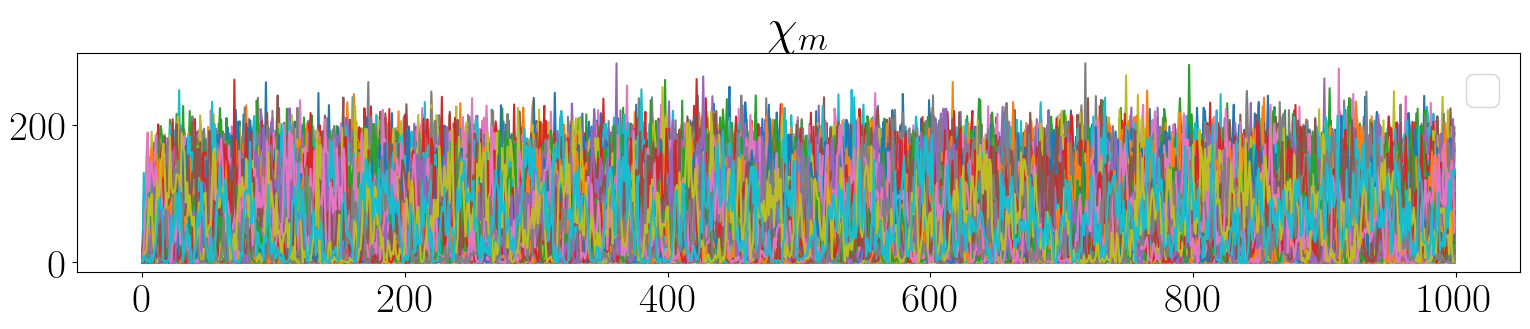

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1095780/3880824500.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


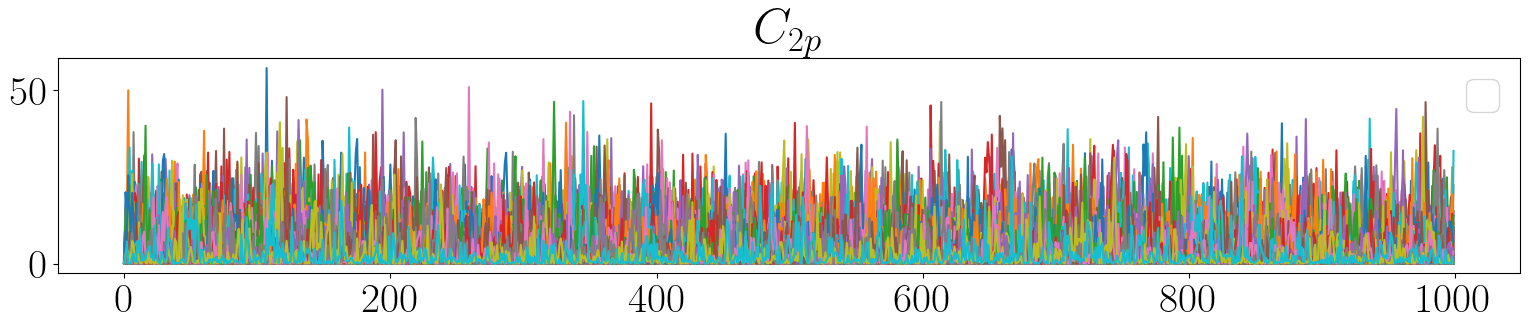

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1095780/3880824500.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


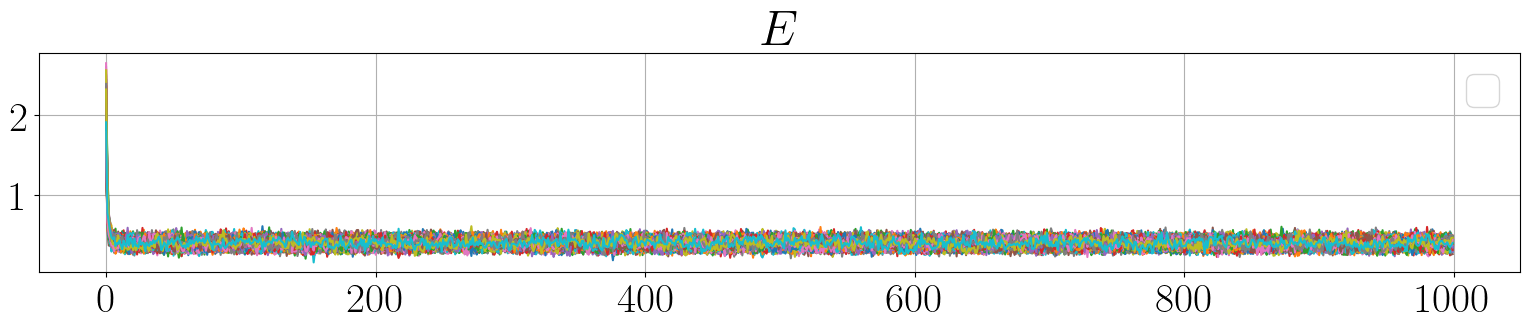

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1095780/3880824500.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


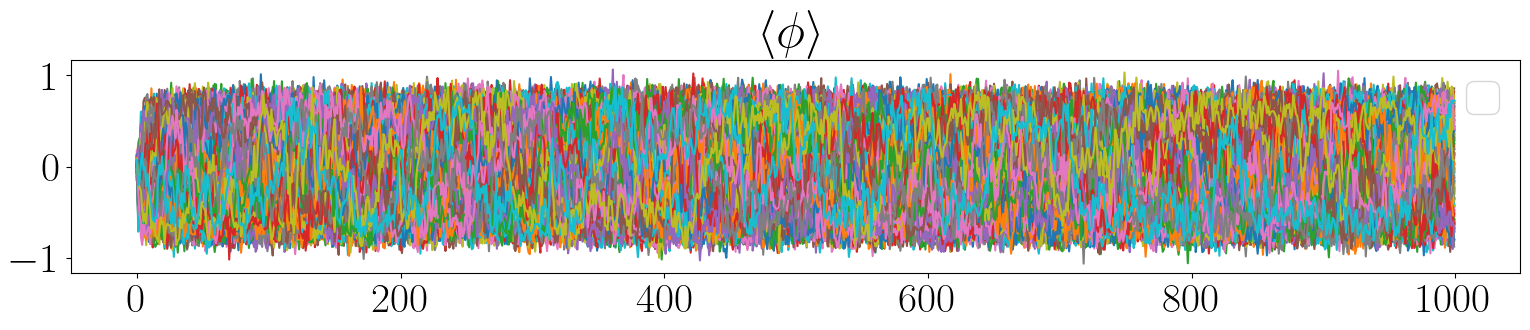

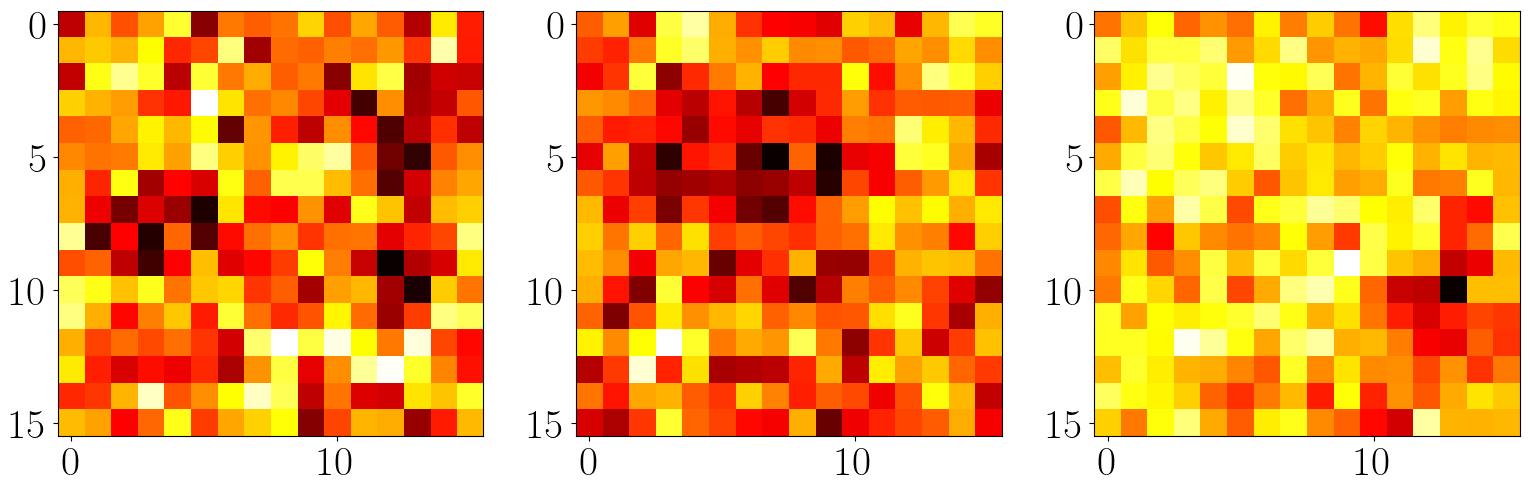

In [8]:
#size of the plot
Nmeas = 1000
Nmeas1 = 1000
plt.figure(figsize=(16, 4))
plt.title(r"$\chi_m$")
plt.plot(range(Nmeas),tr.stack(lchi_m).reshape(Nmeas1,batch_size).to("cpu")[:Nmeas])#, label=r'$\chi_m$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$C_{2p}$")
plt.plot(range(Nmeas),tr.stack(lC2p).reshape(Nmeas1,batch_size).to("cpu")[:Nmeas])#, label=r'$C_{2p}$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$E$")
plt.plot(range(Nmeas),tr.stack(E).reshape(Nmeas1,batch_size).to("cpu")[:Nmeas])#, label=r'$E$')
#y limit 
#plt.ylim(0,80)
#grid
plt.grid()
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$\langle \phi \rangle$")
plt.plot(range(Nmeas),tr.stack(av_phi).reshape(Nmeas1,batch_size).to("cpu")[:Nmeas])#, label=r'$\langle\phi\rangle$')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,3, figsize=(16, 8))
for i in range(0,3):
    ax[i].imshow(phi[i,:,:].to("cpu").detach().numpy(), cmap='hot', interpolation='nearest')

In [24]:
# Reducing max_lag to avoid division by zero 
import importlib
importlib.reload(gm)
import Gamma_error as gm
results_av = gm.gamma_method_with_replicas(gm.split_first_dim_to_list(tr.stack(av_phi).T.unsqueeze(2).to("cpu")), lambda A: A[0], max_lag=1000)

In [25]:
results_av

{'value': -0.01123350951820612,
 'dvalue': 0.02571098068905425,
 'ddvalue': 0.002380870130338758,
 'tau_int': 30.831017755414173,
 'dtau_int': 5.171327373067151,
 'W_opt': 171,
 'Q': 0.9989272482543426,
 'acf': tensor([1.0000, 0.9574, 0.9223, 0.8895, 0.8598, 0.8325, 0.8071, 0.7823, 0.7576,
         0.7346, 0.7133, 0.6927, 0.6739, 0.6554, 0.6376, 0.6200, 0.6016, 0.5837,
         0.5665, 0.5487, 0.5313, 0.5128, 0.4944, 0.4778, 0.4640, 0.4507, 0.4368,
         0.4245, 0.4121, 0.4020, 0.3927, 0.3831, 0.3752, 0.3674, 0.3591, 0.3506,
         0.3417, 0.3334, 0.3247, 0.3170, 0.3086, 0.2987, 0.2889, 0.2791, 0.2694,
         0.2598, 0.2490, 0.2386, 0.2290, 0.2190, 0.2097, 0.2000, 0.1921, 0.1833,
         0.1766, 0.1676, 0.1584, 0.1501, 0.1448, 0.1411, 0.1391, 0.1371, 0.1354,
         0.1321, 0.1289, 0.1257, 0.1228, 0.1199, 0.1186, 0.1160, 0.1117, 0.1087,
         0.1086, 0.1095, 0.1111, 0.1113, 0.1096, 0.1082, 0.1068, 0.1065, 0.1072,
         0.1055, 0.1072, 0.1079, 0.1081, 0.1063, 0.1037, 0.09

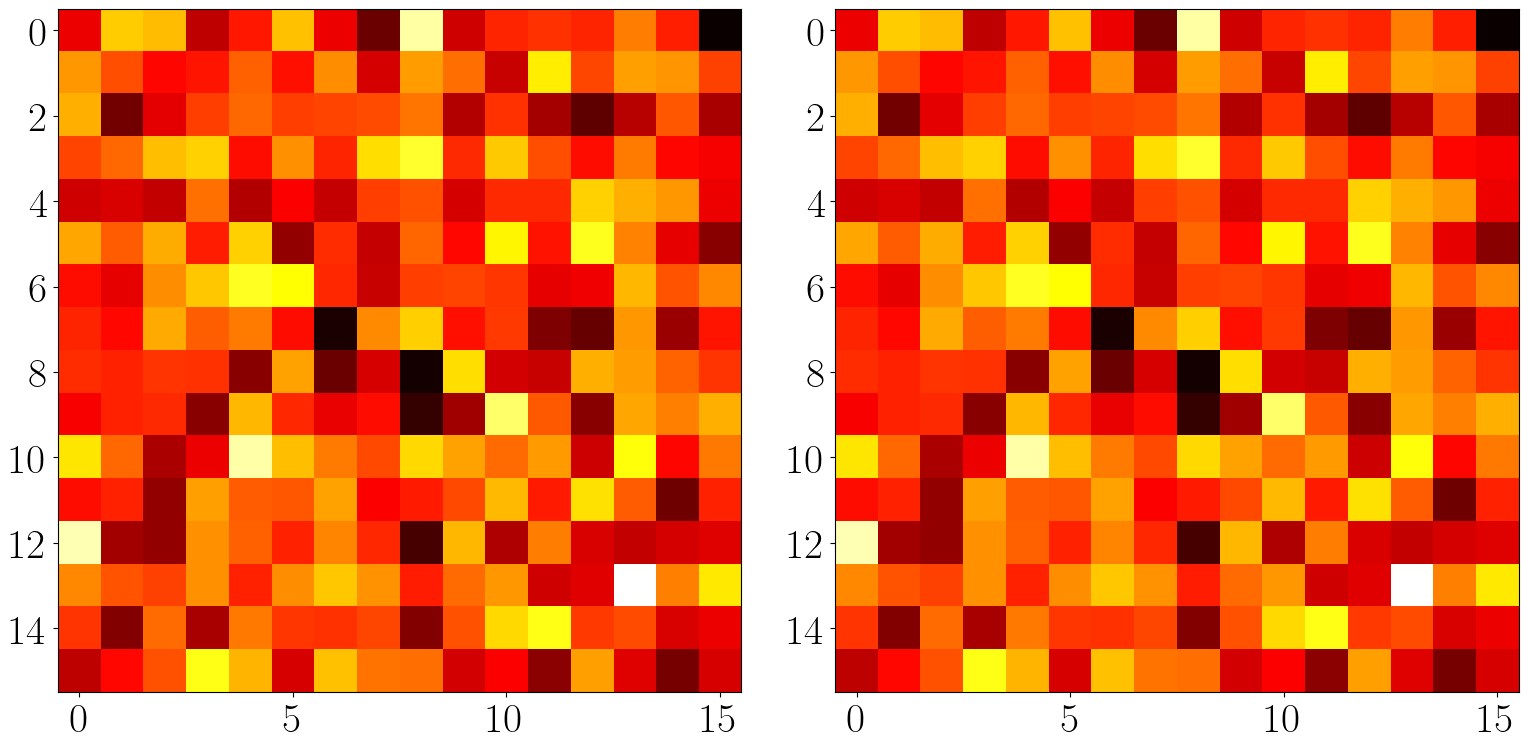

diff shape tensor(-1.6676e-18, device='cuda:0', grad_fn=<MeanBackward0>)


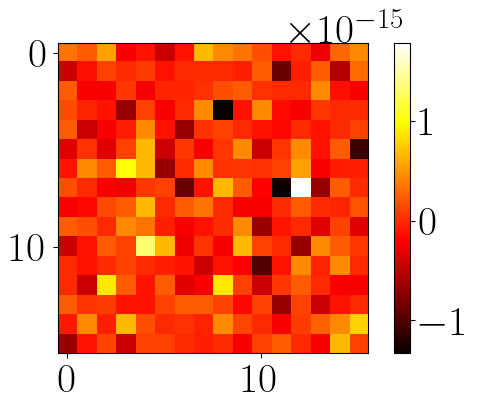

In [15]:
phi_trans,diff=mgf.generate_levels(phi)
#rand number between 0,199

#plot phi_trans and diff
fig, ax = plt.subplots(1,2, figsize=(16, 8))
ax[0].imshow(phi[0,:,:].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
ax[1].imshow(phi_trans[0,:,:].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
# colorbar
plt.show()

print("diff shape",diff.mean())
plt.imshow(diff[0,:,:].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()


In [16]:
phi1, logdet1 = mgf.backward(phi)
phi2, logde2 = mgf.forward(phi1)

dif=phi-phi2
print(tr.norm(dif)/tr.norm(phi))


tensor(4.4288e-16, device='cuda:0', grad_fn=<DivBackward0>)


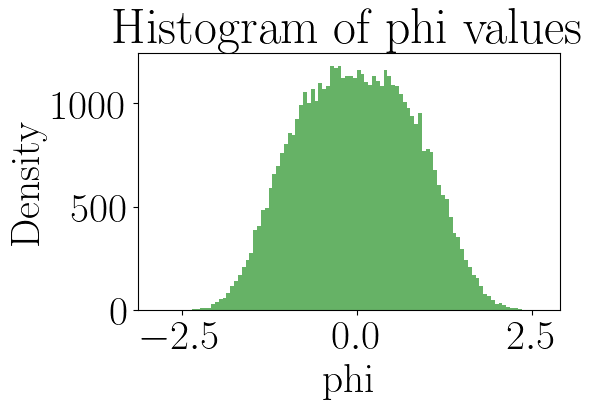

In [9]:
#plot the histogram of phi values

plt.hist(phi.flatten().detach().to('cpu').numpy(), bins=100, alpha=0.6, color='g')
plt.xlabel('phi')
plt.ylabel('Density')
plt.title('Histogram of phi values')
plt.show()


#### plots

In [52]:
#deactivate mgf parameters
for p in mgf.parameters():
    p.requires_grad = False
    #and also graph
    #p.graph = False

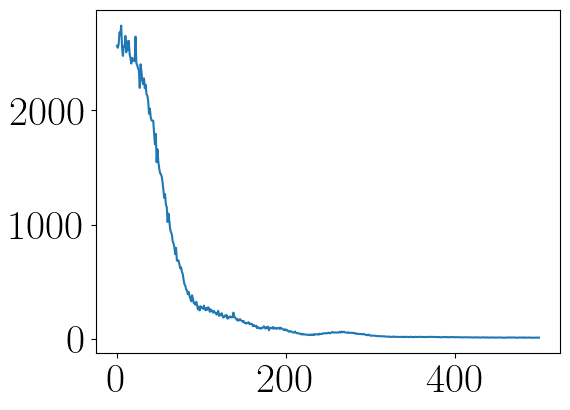

In [33]:
#plot loss
plt.plot(loss_history)
plt.show()


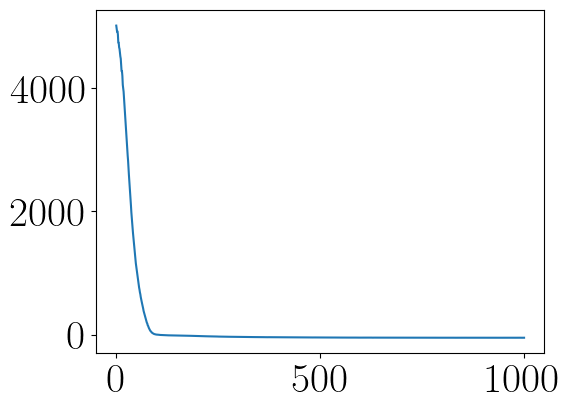

In [39]:
#plot loss
plt.plot(loss_history)
plt.show()


Weights pf the bijector


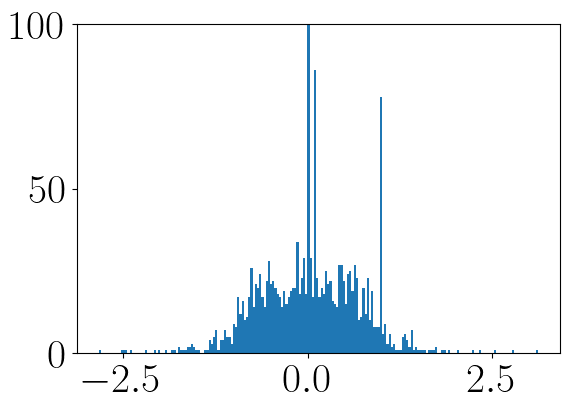

In [40]:
print("Weights pf the bijector")
all_weights = []
for p in mgf.parameters():
    all_weights.append(p.detach().cpu().numpy().flatten())

all_weights = np.concatenate(all_weights)

plt.figure()
plt.hist(all_weights, bins=200)
plt.ylim(0,100)
# Sin titulos ni nada extra
plt.show()

Ploteando histograma de pesos (agregado)...


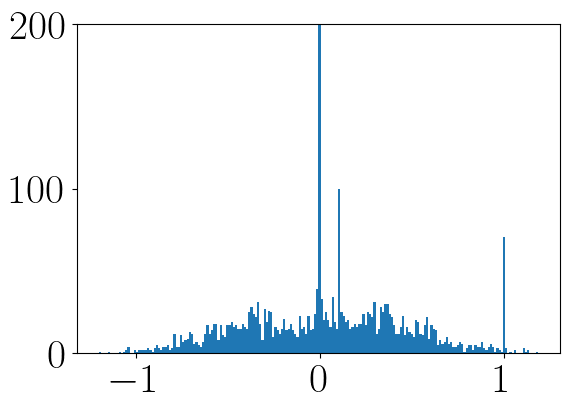

In [22]:
print("Ploteando histograma de pesos (agregado)...")
all_weights = []
for p in mgf.parameters():
    all_weights.append(p.detach().cpu().numpy().flatten())

all_weights = np.concatenate(all_weights)

plt.figure()
plt.hist(all_weights, bins=200)
plt.ylim(0,200)
# Sin titulos ni nada extra
plt.show()

### Meassure things

In [22]:
#import again modile mgmc
#import importlib
#importlib.reload(mgmc)

#import mgmc 

lC2p, lchi_m, E, av_phi, phi = mgmc.get_observables_MCMG(sg,mgf, hmc_f,sgc, mn2c, hmc_c, phi, Nwarm, 100, pp="no",mode="rnvp")

time 18.1040 micro-seconds per HMC trajecrory


/sciclone/pscr/yacahuanamedra/torchQFT/mgmc.py:89: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1724789563135/work/aten/src/ATen/native/Copy.cpp:305.)
  phase=tr.tensor(np.exp(1j*np.indices(tuple(lat))[0]*2*np.pi/lat[0]),dtype=sg.dtype,device=sg.device)


 HMC:  0  DH=  [-0.0021267515341207854, -0.003646828309229022, -0.0015367449508403297, -0.0043246129535816635, -0.008468728262215564, 0.0019398323731536493, -1.329698170593474e-05, 0.00566329971852042, 0.003502800155558816, -0.01367529179833582, 0.012072725820672758, -0.008244967779006629, 0.0007715875258327287, -0.00815011576784741, 0.0043014374384995335, -0.0005782940745575615, 0.008194304365105154, -0.0016764933483273126, 0.06309651848457065, -0.003433004312654475, -0.0030693443623022176, -0.005577181342147242, 0.006066243338693766, 0.0018229805871783356, -0.007493333656782397, 0.0024697538452187473, -0.023022309084041126, -0.00455584719708213, -0.012483203190555514, -0.005931477799009599, -0.0054054991600196445, -0.004176211635893878, 0.004063970959123253, 0.06078519623753209, 0.0009298550427274677, 0.0030752133188798325, -0.012348782773955236, 0.01495355784743424, -0.005140839455123114, 0.04767899253957353, -0.005516635488419297, 0.01106370332536244, -0.012729980647492312, -0.0038

### Autocorrelation time

In [44]:
!pwd

/sciclone/pscr/yacahuanamedra/torchQFT


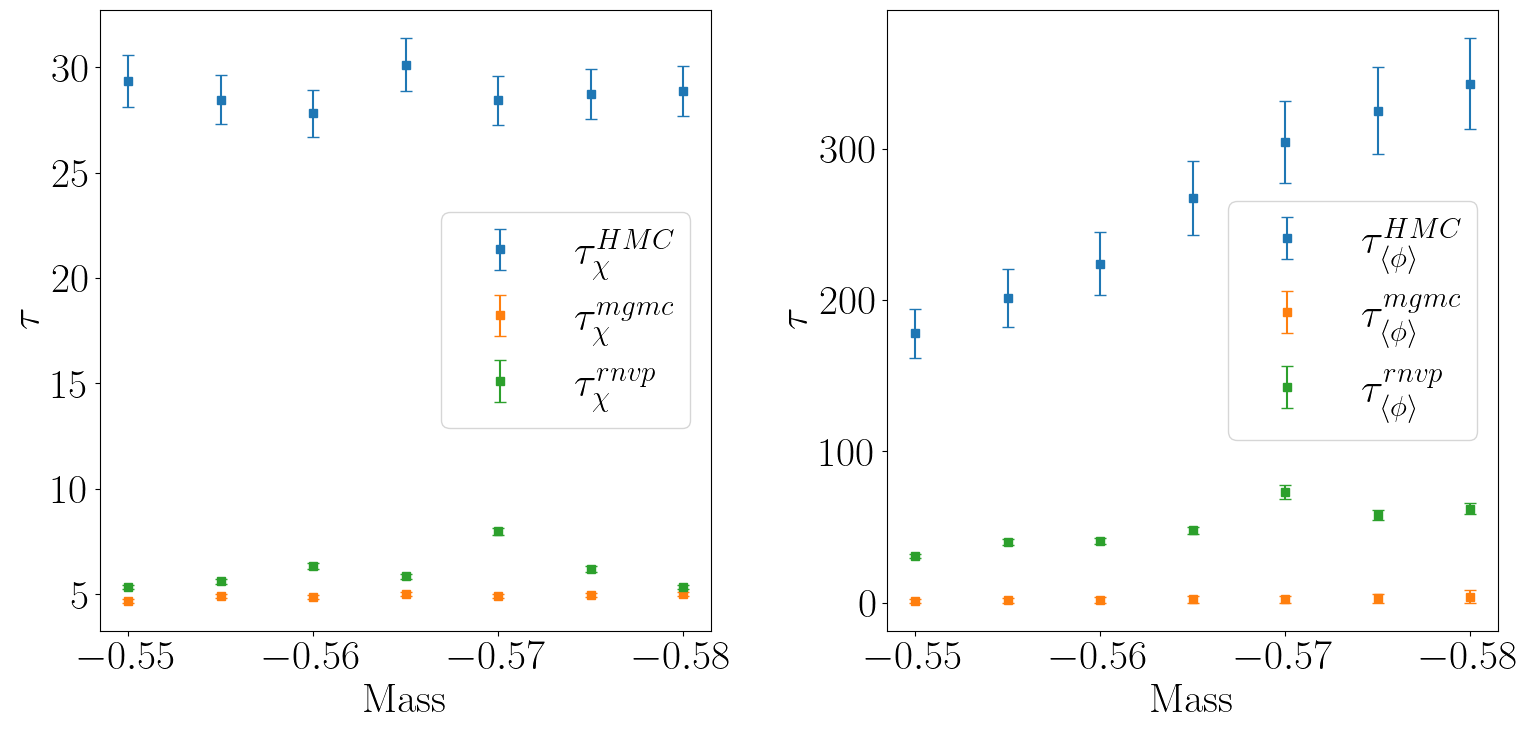

In [21]:
#data = np.loadtxt("MCMG_results_L128_lam2.4.txt", comments="#")
#quiero hacer plots de /phidata_rnvp_flow/MCMG_results_L16_lam2.4.txt
data = np.loadtxt("/sciclone/home/yacahuanamedra/pscr/torchQFT/phi4data_mgmc/MCMG_results_L16_lam2.4.txt", comments="#")
mass_mgmc = data[:, 0]

tau_phi1_mgmc = data[:, 7]
dtau_phi1_mgmc = data[:, 8]

tau_suscept1_mgmc = data[:, 11]
dtau_suscept1_mgmc = data[:, 12]

# Ordenar por masa (importante)
idx = np.argsort(mass_mgmc)
mass_mgmc = mass_mgmc[idx]
tau_phi1_mgmc = tau_phi1_mgmc[idx]
dtau_phi1_mgmc = dtau_phi1_mgmc[idx]
tau_suscept1_mgmc = tau_suscept1_mgmc[idx]
dtau_suscept1_mgmc = dtau_suscept1_mgmc[idx]

data1=np.loadtxt("/sciclone/home/yacahuanamedra/pscr/torchQFT/phi4data_hmc/MCMG_results_L16_lam2.4.txt", comments="#")

mass = data1[:, 0]

tau_phi1 = data1[:, 7]
dtau_phi1 = data1[:, 8]

tau_suscept1 = data1[:, 11]
dtau_suscept1 = data1[:, 12]

# Ordenar por masa (importante)
idx = np.argsort(mass)
mass = mass[idx]
tau_phi1 = tau_phi1[idx]
dtau_phi1 = dtau_phi1[idx]
tau_suscept1 = tau_suscept1[idx]
dtau_suscept1 = dtau_suscept1[idx]

data2=np.loadtxt("/sciclone/home/yacahuanamedra/pscr/torchQFT/phi4data_rnvp_flow/MCMG_results_L16_lam2.4.txt", comments="#")

mass2 = data2[:, 0]

tau_phi2 = data2[:, 7]
dtau_phi2 = data2[:, 8]

tau_suscept2 = data2[:, 11]
dtau_suscept2 = data2[:, 12]

# Ordenar por masa (importante)
idx = np.argsort(mass2)
mass2 = mass2[idx]
tau_phi2 = tau_phi2[idx]
dtau_phi2 = dtau_phi2[idx]
tau_suscept2 = tau_suscept2[idx]
dtau_suscept2 = dtau_suscept2[idx]


fig, ax = plt.subplots(1,2, figsize=(16, 8))

#plt.errorbar(mass, tau_phi1, yerr=dtau_phi1,fmt='o', capsize=4, label=r"$\tau_{\langle\phi\rangle}$")

ax[0].errorbar(mass, tau_suscept1, yerr=dtau_suscept1,fmt='s', capsize=4, label=r"$\tau_{\chi}^{HMC}$")

ax[0].errorbar(mass_mgmc, tau_suscept1_mgmc, yerr=dtau_suscept1_mgmc,fmt='s', capsize=4, label=r"$\tau_{\chi}^{mgmc}$")

ax[0].errorbar(mass2, tau_suscept2, yerr=dtau_suscept2,fmt='s', capsize=4, label=r"$\tau_{\chi}^{rnvp}$")



ax[0].set_xlabel("Mass")
ax[0].set_ylabel(r"$\tau$")
#reverse x axis
ax[0].invert_xaxis()
ax[0].legend()
plt.tight_layout()
#grid
plt.grid()

ax[1].errorbar(mass, tau_phi1, yerr=dtau_phi1,fmt='s', capsize=4, label=r"$\tau_{\langle\phi\rangle}^{HMC}$")

ax[1].errorbar(mass_mgmc, dtau_phi1_mgmc, yerr=dtau_phi1_mgmc,fmt='s', capsize=4, label=r"$\tau_{\langle\phi\rangle}^{mgmc}$")

ax[1].errorbar(mass2, tau_phi2, yerr=dtau_phi2,fmt='s', capsize=4, label=r"$\tau_{\langle\phi\rangle}^{rnvp}$")




plt.xlabel("Mass")
plt.ylabel(r"$\tau$")
#reverse x axis
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
#grid
plt.grid()
#plt.yscale("log")

plt.show()

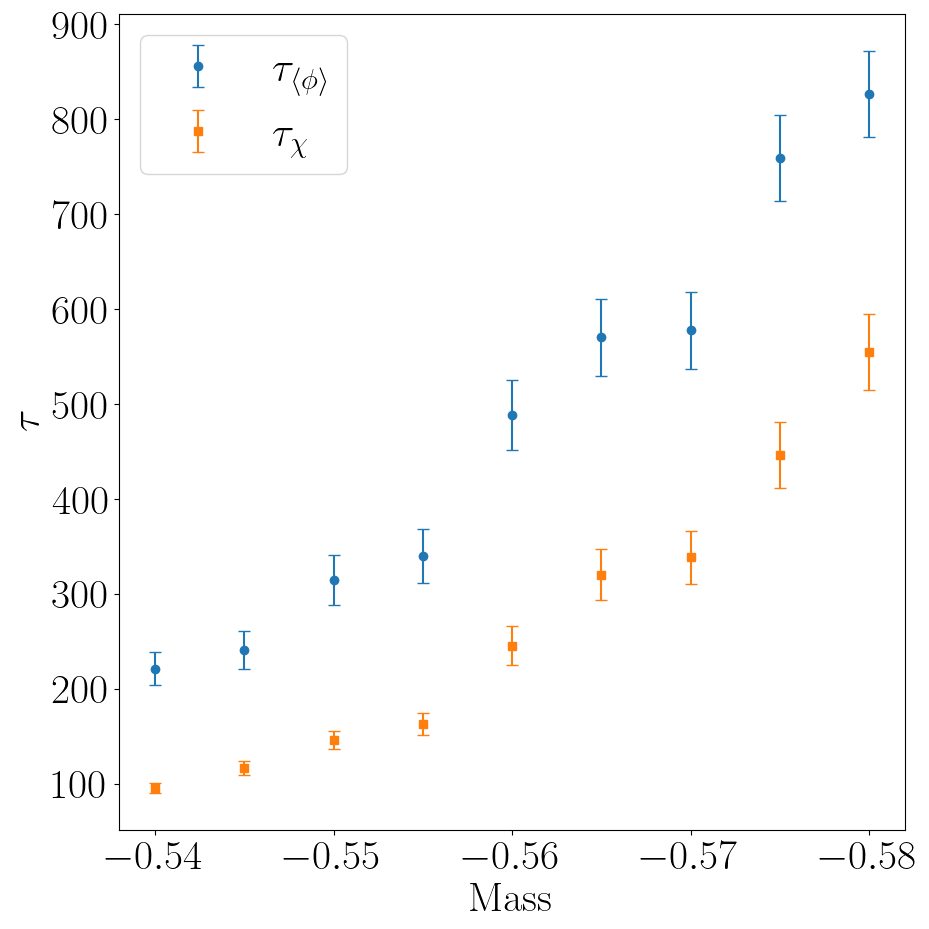

In [47]:
data = np.loadtxt("MCMG_results_L128_lam2.4.txt", comments="#")

mass = data[:, 0]

tau_phi1 = data[:, 7]
dtau_phi1 = data[:, 8]

tau_suscept1 = data[:, 11]
dtau_suscept1 = data[:, 12]

# Ordenar por masa (importante)
idx = np.argsort(mass)
mass = mass[idx]
tau_phi1 = tau_phi1[idx]
dtau_phi1 = dtau_phi1[idx]
tau_suscept1 = tau_suscept1[idx]
dtau_suscept1 = dtau_suscept1[idx]

plt.figure(figsize=(10,10))

plt.errorbar(
    mass, tau_phi1, yerr=dtau_phi1,
    fmt='o', capsize=4, label=r"$\tau_{\langle\phi\rangle}$"
)

plt.errorbar(
    mass, tau_suscept1, yerr=dtau_suscept1,
    fmt='s', capsize=4, label=r"$\tau_{\chi}$"
)

plt.xlabel("Mass")
plt.ylabel(r"$\tau$")
#reverse x axis
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
import torch
import gc

total = 0
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj):
            size_MB = obj.element_size() * obj.nelement() / 1024**2
            total += size_MB
            print(f"{type(obj):<30} | {obj.size()} | {size_MB:.2f} MB")
    except:
        pass

print(f"\nTotal GPU memory used by tracked tensors: {total:.2f} MB")

/sciclone/home/yacahuanamedra/.conda/envs/torchQFT-env/lib/python3.12/site-packages/torch/__init__.py:836: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)



Total GPU memory used by tracked tensors: 102.91 MB


In [16]:
#memory usage of phi in MB
phi.element_size() * phi.nelement() / 1024**2

0.0048828125

In [27]:
tr.cuda.empty_cache()

In [118]:
free_memory, total_memory = tr.cuda.mem_get_info()
print(f"Total GPU memory: {total_memory / (1024**3):.2f} GB")
print(f"Free GPU memory: {free_memory / (1024**3):.2f} GB")
print(tr.cuda.memory_summary(device=None, abbreviated=False))


Total GPU memory: 23.50 GB
Free GPU memory: 9.69 GB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 270003 KiB |  13717 MiB |  92598 GiB |  92597 GiB |
|       from large pool |  16640 KiB |  12816 MiB |    425 GiB |    425 GiB |
|       from small pool | 253363 KiB |    901 MiB |  92173 GiB |  92172 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 270003 KiB |  13717 MiB |  92598 GiB |  92597 GiB |
|       from

In [29]:
!nvidia-smi

Thu Nov 13 20:22:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58.02              Driver Version: 555.58.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           On  |   00000000:04:00.0 Off |                    0 |
| N/A   29C    P0             30W /  250W |    7175MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [63]:
mass_grid2=np.linspace(-.585,-0.54,2)
tau_phi2=np.zeros_like(mass_grid2)
tau_suscept2=np.zeros_like(mass_grid2)
sss=0
for mas in mass_grid2:
    L=64
    lat = [L,L]
    # This set of params is very very close to critical.
    lam = 2.4
    #
    Nwarm = 500
    Nmeas = 2000
    Nskip = 1
    batch_size = 1

    Vol = np.prod(lat)
    sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device)
    phi = sg.hotStart()
    mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
    print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
    hmc = u.hmc(T=sg,I=mn2,verbose=False)
    rg = phimg.RGlayer("average",batch_size=batch_size)
    

    lC2p, lchi_m, E, av_phi, phi = get_observables_MCMG(sg,rg, hmc, phi, Nwarm, Nmeas, Lev=1)
    tau_phi2[sss],tau_suscept2[sss] = get_autocorrelationtime(av_phi, lchi_m)
    sss+=1
    m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi=get_observables(lC2p, lchi_m, E, av_phi, phi)

torch.Size([1, 64, 64]) 4096 tensor(-0.0087, device='cuda:0') tensor(0.9844, device='cuda:0')
time 0.0052 micro-seconds per HMC trajecrory


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
mass_grid3=np.linspace(-.585,-0.54,6)
tau_phi3=np.zeros_like(mass_grid3)
tau_suscept3=np.zeros_like(mass_grid3)
sss=0
for mas in mass_grid3:
    L=64
    lat = [L,L]
    # This set of params is very very close to critical.
    lam = 2.4
    #
    Nwarm = 10
    Nmeas = 2000
    Nskip = 1
    batch_size = 1

    Vol = np.prod(lat)
    sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device)
    phi = sg.hotStart()
    mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
    print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
    hmc = u.hmc(T=sg,I=mn2,verbose=False)
    rg = NonLinearRGlayer(channels=1, hidden_channels=1, batch_size=batch_size)
    

    lC2p, lchi_m, E, av_phi, phi = get_observables_MCMG(sg,rg, hmc, phi, Nwarm, Nmeas, Lev=1)
    tau_phi3[sss],tau_suscept3[sss] = get_autocorrelationtime(av_phi, lchi_m)
    sss+=1
    #m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi=get_observables(lC2p, lchi_m, E, av_phi, phi)

torch.Size([1, 64, 64]) 4096 tensor(-0.0151) tensor(0.9927)
time 0.1403 micro-seconds per HMC trajecrory
k=  0 (av_phi,chi_m, c2p, E)  -0.015104491 0.9344846 0.09005918706005746 1.9716909


k=  10 (av_phi,chi_m, c2p, E)  -0.37677017 581.4508 16.373593413122094 0.40607983
k=  20 (av_phi,chi_m, c2p, E)  -0.509234 1062.1718 18.38932896016239 0.39865112
k=  30 (av_phi,chi_m, c2p, E)  -0.6199784 1574.3928 9.16200502544789 0.37060016
k=  40 (av_phi,chi_m, c2p, E)  -0.67207795 1850.1172 7.531855072658757 0.34692156
k=  50 (av_phi,chi_m, c2p, E)  -0.7205291 2126.4883 6.763256786391959 0.36446297
k=  60 (av_phi,chi_m, c2p, E)  -0.74507403 2273.8342 2.5607110574959373 0.3536834
k=  70 (av_phi,chi_m, c2p, E)  -0.859984 3029.2888 3.814437206222709 0.34161174
k=  80 (av_phi,chi_m, c2p, E)  -0.7739779 2453.675 0.5661553252756875 0.37053555
k=  90 (av_phi,chi_m, c2p, E)  -0.76859945 2419.692 1.883323628224898 0.31652868
k=  100 (av_phi,chi_m, c2p, E)  -0.7925014 2572.5273 4.0118689390430555 0.3192715
k=  110 (av_phi,chi_m, c2p, E)  -0.79144424 2565.6687 0.49470373007104335 0.32894552
k=  120 (av_phi,chi_m, c2p, E)  -0.7519648 2316.0876 2.631338128157484 0.33890897
k=  130 (av_phi,chi_m,

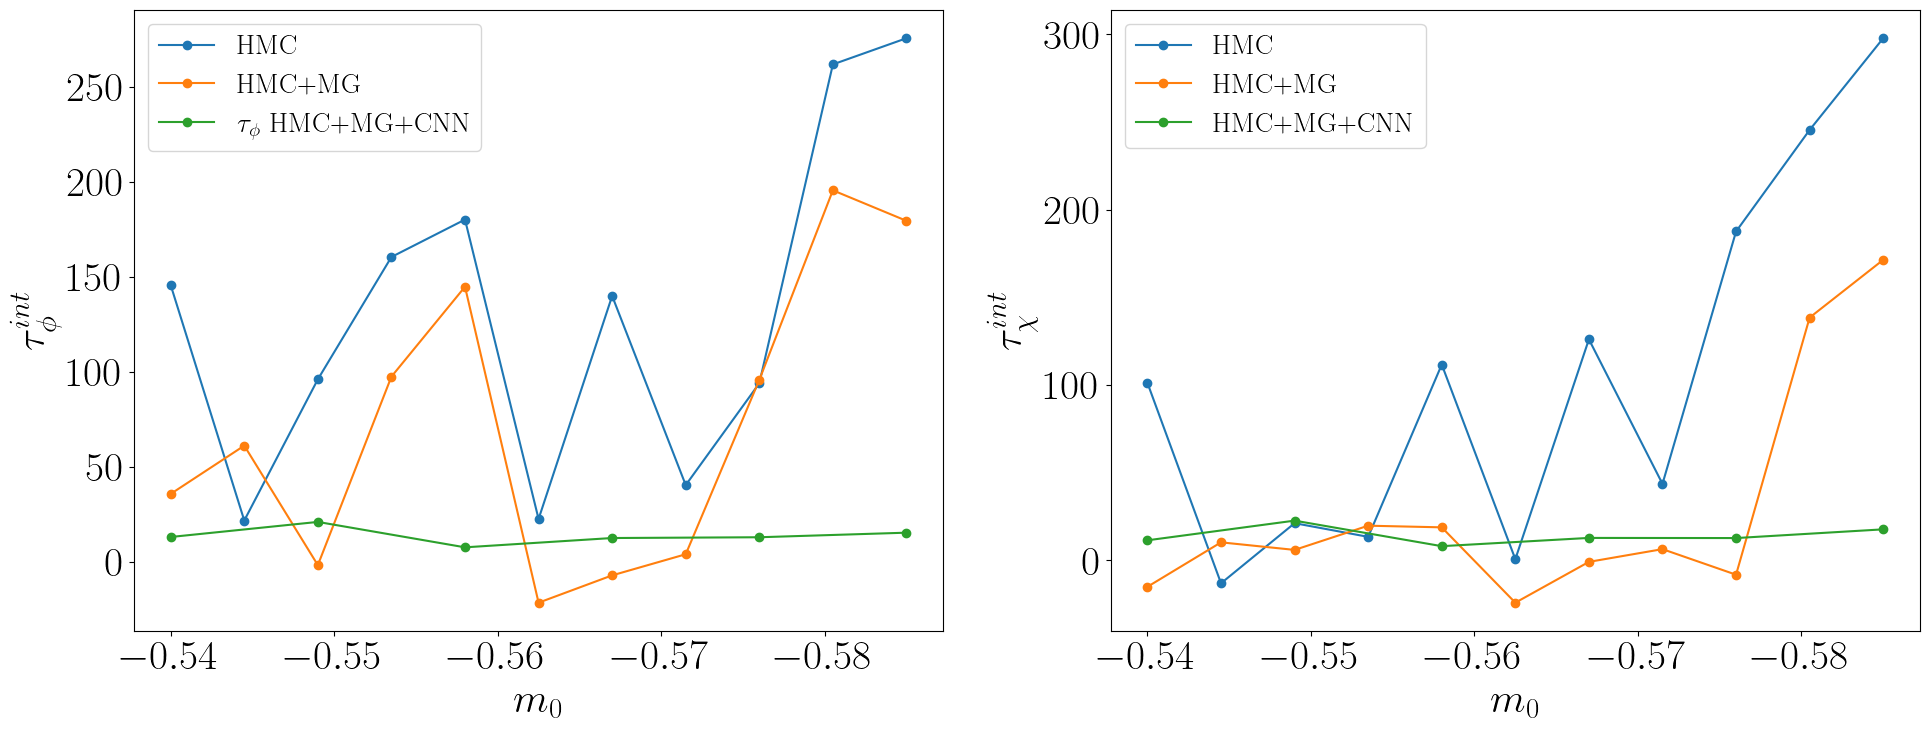

In [25]:
fig, ax = plt.subplots(1,2, figsize=(20, 8))
#reverse mass axis ax
ax[0].invert_xaxis()
ax[0].plot(mass_grid1,tau_phi1,'o-',label=r'HMC')
ax[0].plot(mass_grid2,tau_phi2,'o-',label=r'HMC+MG')
ax[0].plot(mass_grid3,tau_phi3,'o-',label=r'$\tau_{\phi}$ HMC+MG+CNN')
ax[0].set_xlabel(r'$m_0$', fontsize=30)
ax[0].set_ylabel(r'$\tau_{\phi}^{int}$', fontsize=30)
ax[0].legend(fontsize=20)
ax[1].invert_xaxis()
ax[1].plot(mass_grid1,tau_suscept1,'o-',label=r'HMC')
ax[1].plot(mass_grid2,tau_suscept2,'o-',label=r'HMC+MG')
ax[1].plot(mass_grid3,tau_suscept3,'o-',label=r'HMC+MG+CNN')
ax[1].set_xlabel(r'$m_0$', fontsize=30)
ax[1].set_ylabel(r'$\tau_{\chi}^{int}$', fontsize=30)
ax[1].legend(fontsize=20)
#plt.savefig("tau_comparison.svg", bbox_inches='tight',dpi=300)
plt.show()

shape of the original field torch.Size([1, 64, 64])
coarsening level  0  field shape  torch.Size([1, 64, 64])
shape of fine field  torch.Size([1, 64, 64])
shape of new field  torch.Size([1, 64, 64])
reject rate:  [1.0]
tensor(1.)


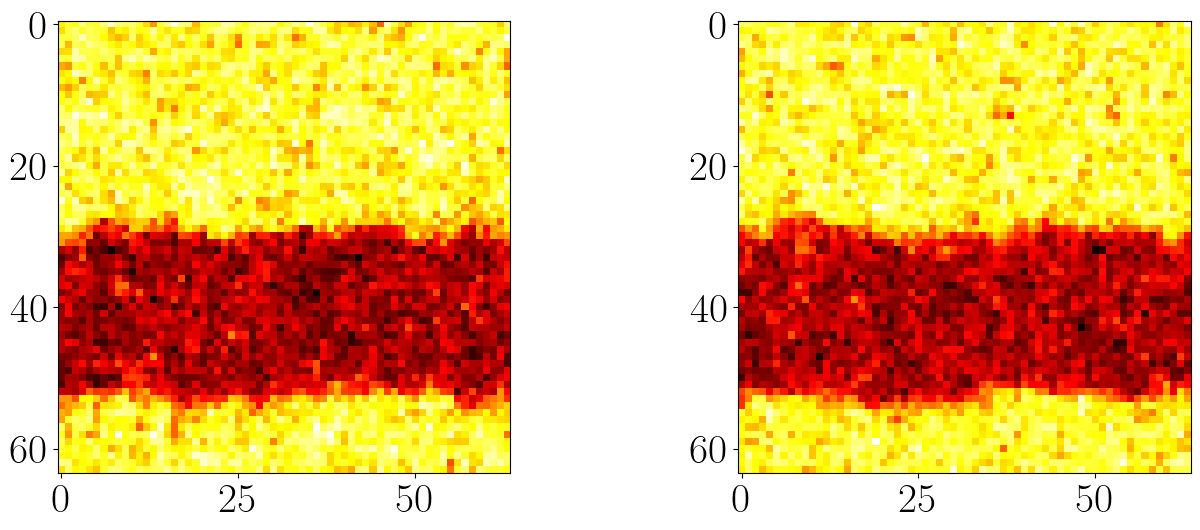

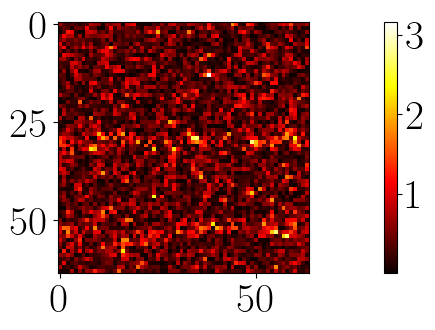

In [ ]:

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].imshow(phi[0,:,:], cmap='hot', interpolation='nearest')
phi_new,accept=V_cycle(phi,sg,rg,hmc,1,1,Nlevels=1)
print("shape of new field ",phi_new.shape)
ax[1].imshow(phi_new[0,:,:], cmap='hot', interpolation='nearest')
print("reject rate: ",accept )
diff=(phi-phi_new)
#plot diff
print(tr.tensor(accept).sum()/len(accept))
plt.figure(figsize=(16, 4))
plt.imshow(tr.abs(diff[0,:,:]).detach(), cmap='hot', interpolation='nearest')
plt.colorbar()


In [ ]:
#still need to change the code of phi_coarse try Vcycle instead
def Wcycle(phi,sg,rg,hmc_f,m1,m2,Nlevels=2,Nskip=1):

    sgc = phi4_c1(sg,rg)
    mn2c = i.minnorm2(sgc.force,sgc.evolveQ,7,1.0)
    hmcc = u.hmc(T=sgc,I=mn2c,verbose=False)
    sgc.generate_cfg_levels(phi,Nlevels)
    phic=sgc.phis[-1]
    phic_up=hmcc.evolve(phic,Nskip)
    #now go back up
    for sss in reversed(range(Nlevels-1)):
        phic_up= rg.refine(phic_up,sgc.pics[sss])
    
    phic_up=hmc_f.evolve(phic_up,m1)
    return phic_up, hmcc.AcceptReject

256

In [56]:
phi_c = sg2.phis[-1]
phi_c.requires_grad_()
S = sg2.action(phi_c)
print("action", S)
grad = tr.autograd.grad(S.sum(), phi_c, retain_graph=True)[0]
print("grad ok? nan:", tr.isnan(grad).any(), "shape:", grad.shape)

action tensor([6299.9238], grad_fn=<SubBackward0>)
grad ok? nan: tensor(False) shape: torch.Size([1, 64, 64])


shape of the original field torch.Size([1, 64, 64])
coarsening level  0  field shape  torch.Size([1, 64, 64])
coarsening level  1  field shape  torch.Size([1, 32, 32])
coarsening level  2  field shape  torch.Size([1, 16, 16])
torch.Size([1, 8, 8])
reject rate:  [1.0]
tensor(1.)


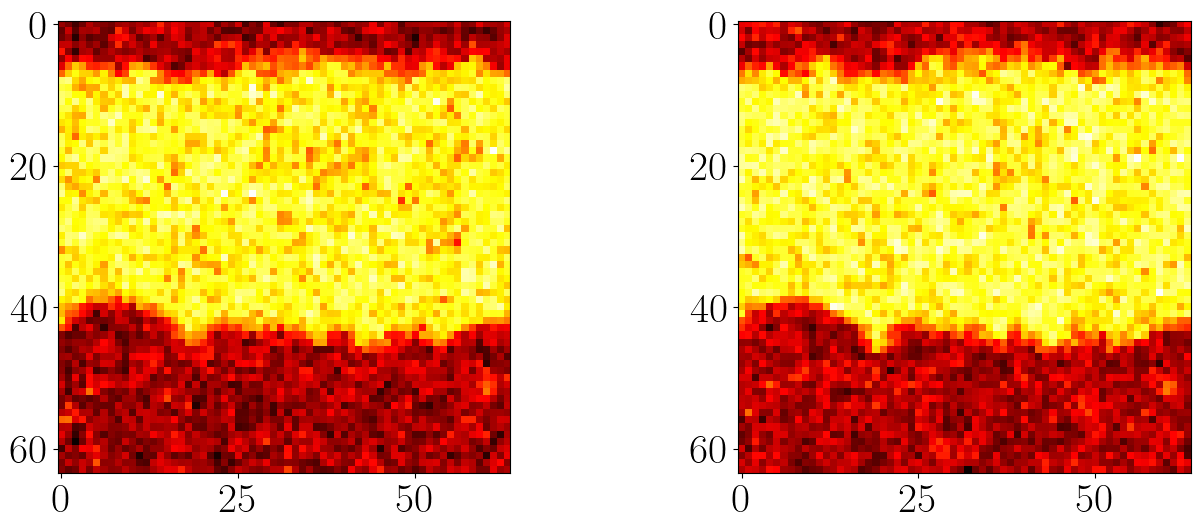

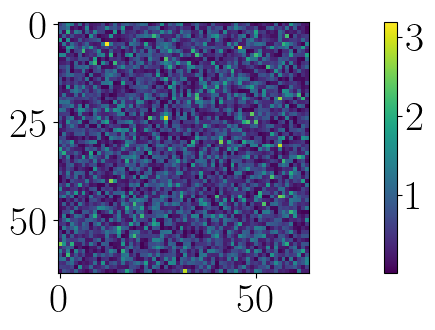

In [ ]:
import phi4_mg as phimg
#rg = NonLinearRGlayer("average",batch_size=batch_size)

rg = NonLinearRGlayer(channels=1, hidden_channels=1, batch_size=batch_size)
import integrators as i

sg2 = phi4_c1(sg,rg)
mn2_2 = i.minnorm2(sg2.force,sg2.evolveQ,7,1.0)
hmc_2 = u.hmc(T=sg2,I=mn2_2,verbose=False)
Nlevels=3
sg2.generate_cfg_levels(phi,Nlevels)
phi2=sg2.phis[-1]

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].imshow(phi[0,:,:], cmap='hot', interpolation='nearest')
print(phi2.shape)
#remove gradient
#phi2 = phi2.detach()
#ax[1].imshow(phi2[0,:,:].detach(), cmap='hot', interpolation='nearest')

phinew = hmc_2.evolve(phi2,1)

for sss in reversed(range(Nlevels)):
    phinew= rg.refine(phinew,sg2.pics[sss])

phinew=hmc.evolve(phinew,10)
ax[1].imshow(phinew[0,:,:].detach(), cmap='hot', interpolation='nearest')
print("reject rate: ",hmc_2.AcceptReject )
diff=(phi-phinew)
#plot diff
print(tr.tensor(hmc_2.AcceptReject).sum()/len(hmc_2.AcceptReject))
plt.figure(figsize=(16, 4))
plt.imshow(tr.abs(diff[0,:,:]).detach(), interpolation='nearest')
plt.colorbar()

 MG flow works but I have to figure out the coarsening procedure

In [24]:
normal = distributions.Normal(tr.zeros(Vol),tr.ones(Vol))
prior= distributions.Independent(normal, 1)

mg = phimg.MGflow([L,L],phimg.FlowBijector,phimg.RGlayer("average",batch_size==2),prior)
#print("The MG module: ",mg)
x = mg(phi)
#print(x)
z,J = mg.backward(x)

print("Test reversibility (must be zero): ",(z-phi).abs().mean().detach().numpy())

z = mg.sample(batch_size)
print(z.shape,x.shape)
J = mg.log_prob(x)
print("the logprobs are: ",J.detach().numpy())

def jwrap(x):
    z,_=mg.backward(x)
    return z

torchJacM = tr.autograd.functional.jacobian(jwrap,x)
print("Autograd jacobian matrix shape:",torchJacM.shape)
torchJacM = torchJacM.reshape(batch_size,Vol,batch_size,Vol)
print("Autograd jacobian matrix reshaped:",torchJacM.shape)
log_dets = []
diffs = []
for k in range(1):
    foo = torchJacM[k,:,k,:].squeeze()
    ldet  = np.log(foo.det().numpy())
    log_dets.append(ldet)
    diffs.append(np.abs(ldet - J[k].detach().numpy())/Vol)

print("log(Jacobians): ",log_dets)
print("Differences   : ",diffs)
    

Initializing MGflow module with size:  32
Using depth:  5
Using rg type:  average
(depth, size):  0 [32, 32]
(depth, size):  1 [16, 16]
(depth, size):  2 [8, 8]
(depth, size):  3 [4, 4]
(depth, size):  4 [2, 2]
Test reversibility (must be zero):  2.6313965e-06
torch.Size([2, 32, 32]) torch.Size([2, 32, 32])
the logprobs are:  [-6511.4326 -6283.6553]
Autograd jacobian matrix shape: torch.Size([2, 32, 32, 2, 32, 32])
Autograd jacobian matrix reshaped: torch.Size([2, 1024, 2, 1024])
log(Jacobians):  [62.896713]
Differences   :  [6.420243263244629]


In [26]:
Vol=np.prod(lat)
[phi.shape[1], phi.shape[2]],lat

([256, 256], [256, 256])

In [ ]:
lC2p_c = []
lchi_m_c = []
E_c = []
av_phi_c = []
lat_c=[phinew.shape[1],phinew.shape[2]]
Vol_c = np.prod(lat_c)
phase_c=tr.tensor(np.exp(1j*np.indices(tuple(lat_c))[0]*2*np.pi/lat_c[0]))
phi=sg.hotStart()
mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
hmc = u.hmc(T=sg,I=mn2,verbose=False)
for k in range(Nmeas):
    ttE = sg.action(phi)/Vol
    E.extend(ttE)
    av_sigma = tr.mean(phi.view(sg.Bs,Vol),axis=1)
    av_phi.extend(av_sigma)
    chi_m = av_sigma*av_sigma*Vol
    p1_av_sig = tr.mean(phi.view(sg.Bs,Vol)*phase.view(1,Vol),axis=1)
    C2p = tr.real(tr.conj(p1_av_sig)*p1_av_sig)*Vol
    if(k%10==0):
        print("k= ",k,"(av_phi,chi_m, c2p, E) ", av_sigma.mean().numpy(),chi_m.mean().numpy(),C2p.mean().numpy(),ttE.mean().numpy())
    lC2p.extend(C2p)
    lchi_m.extend(chi_m)


    phi = hmc.evolve(phi,Nskip)

In [ ]:
phinew=hmc.evolve(phinew,10)

torch.Size([5, 128, 128]) 16384 tensor(0.0773) tensor(3.6547)


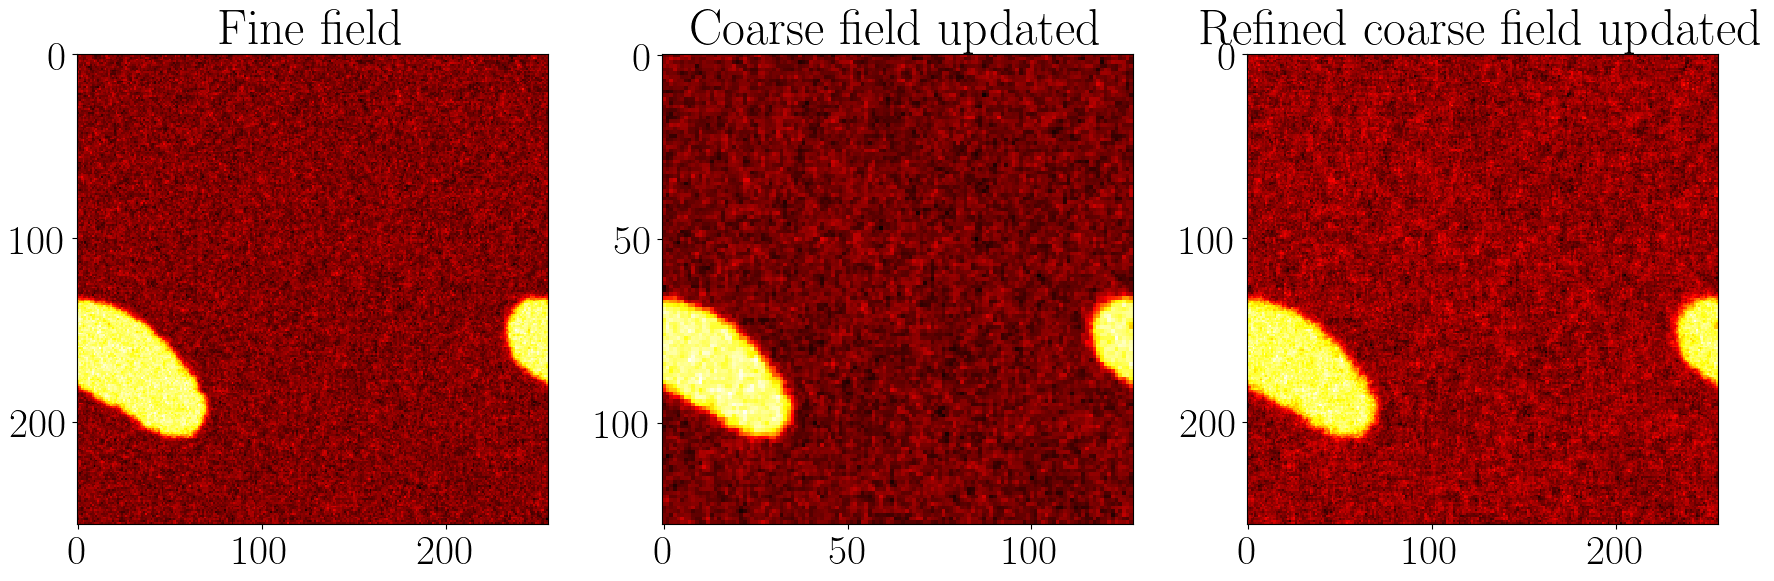

In [ ]:
#define the new lattice and simulate there but starting with the field phi2
L2 = L//2
lat2 = [L2,L2]
sg2 = s.phi4(lat2,lam,mas,batch_size=batch_size,device=device)
#phi2 = sg2.hotStart()
mn2_2 = i.minnorm2(sg2.force,sg2.evolveQ,7,1.0)
phi2 = phi2
print(phi2.shape,Vol//4,tr.mean(phi2),tr.std(phi2))

#mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
#print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
hmc_2 = u.hmc(T=sg2,I=mn2_2,verbose=False)
phi2 = hmc_2.evolve(phi2,1)

# If we want to come back to the fine lattice
rphi = rg.refine(phi2,pi)
rphi.shape
fig, ax= plt.subplots(1,3, figsize=(18,6))
ax[0].imshow(phi[0,:,:], cmap='hot', interpolation='nearest')
ax[0].set_title(f"Fine field")
ax[1].imshow(phi2[0,:,:], cmap='hot', interpolation='nearest')
ax[1].set_title(f"Coarse field updated")
ax[2].imshow(rphi[0,:,:], cmap='hot', interpolation='nearest')
ax[2].set_title(f"Refined coarse field updated")
plt.show()


This is a naive example of updating but with the wrong distribution. Fortunatelly, this is a linear transformation and the jacobian is 1 from $\psi, \pi \rightarrow \phi$

In [5]:
from phi4_mg import MGflow, FlowBijector, RGlayer

device = "cpu"
print(f"Using {device} device")

L=128

V=L*L
batch_size=4
lam =0.5
mass= -0.2
o  = p.phi4([L,L],lam,mass,batch_size=batch_size)

phi = o.hotStart()

#set up a prior
normal = distributions.Normal(tr.zeros(V),tr.ones(V))
prior= distributions.Independent(normal, 1)

mg = MGflow([L,L],FlowBijector,RGlayer("average"),prior)
#print("The MG module: ",mg)
x = mg(phi)
#print(x)
z,J = mg.backward(x)


print("Test reversibility (must be zero): ",(z-phi).abs().mean().detach().numpy())

z = mg.sample(batch_size)
print(z.shape,x.shape)
J = mg.log_prob(x)
print("the logprobs are: ",J.detach().numpy())


Using cpu device
Initializing MGflow module with size:  128
Using depth:  7
Using rg type:  average
(depth, size):  0 [128, 128]
(depth, size):  1 [64, 64]
(depth, size):  2 [32, 32]
(depth, size):  3 [16, 16]
(depth, size):  4 [8, 8]
(depth, size):  5 [4, 4]
(depth, size):  6 [2, 2]
Test reversibility (must be zero):  1.9628638e-07
torch.Size([4, 128, 128]) torch.Size([4, 128, 128])
the logprobs are:  [-24903.758 -24681.896 -24618.16  -24608.506]


In [13]:
mg.backward(phi)[1]

tensor([-1422.5790, -1435.3324, -1445.6223, -1395.2395],
       grad_fn=<AddBackward0>)